# Wind Turbine Accidents: A Data Mining Study

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import scipy.stats as stats
import scipy.special as sp
from scipy.stats import norm
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from itertools import cycle
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.cluster import fowlkes_mallows_score
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Input,Dense

In [2]:
raw_dataset = pd.read_csv('News.Database.csv')

In [3]:
pd.set_option('display.max_columns', None)

raw_dataset.head()

,Accident No,Accident type,Site/area\n,Country\n,Details\n,Web reference/link\n,Year,Month,Day,Turbine Type,Manufacturer,Power of Turbine (KW),PowerOfWindFarm (KW),Offshore,During Construction,FULL-DATE,Outcome,Death,Fire,Injury,Mechanical,Structural Break,Transport Accident,Component,Cause,CauseCategory,Source Database,Source of the News,Title of the article
0,1.0,Wind,Tjaereborg,Denmark,Damage to all 3 blades,http://www.modernpowersystems.com/story.asp?st...,2002,11,4,Vestas 2000 KW,Vestas,2000,19000,1,0,"April 11, 2002",Structural break,0.0,0.0,0.0,0.0,1.0,0.0,Blade,Human (interference in control systems),Human,LexisNexis,Major World Publications,Bending with the wind
1,2.0,Wind,Jiangsu,China,5 died & 4 injured workers,http://www.chinadaily.com.cn/china/2012-03/11/...,2012,3,10,UNKNOWN,UNKNOWN,UNKNOWN,5000,1,1,"October 3, 2012",Structural break,1.0,0.0,1.0,0.0,1.0,0.0,UNKNOWN,Mechanical (platform collapse at construction ...,Mechanical,LexisNexis,Modern Power System,Death toll in China construction site accident...
2,3.0,Wind,Ireland,UK,The turbine came loose after bolts attaching i...,http://www.modernpowersystems.com/story.asp?st...,2009,1,UNKNOWN,Enercon 2000 KW,Enercon,2000,4000,0,0,UNKNOWN,Structural break,0.0,0.0,0.0,1.0,1.0,0.0,Bolt,Mechanical (material fatigue),Mechanical,LexisNexis,The Sunday Telegraph,ET 'not to blame'
3,4.0,Wind,"Berwickshire, Scotland",UK,A 30m turbine near Coldingham was deliberately...,http://www.windbyte.co.uk/safety.html,2011,12,7,Hannevind 22 KW,Hannevind,22,UNKNOWN,0,0,"December 7, 2011",Mechanical,0.0,0.0,0.0,1.0,0.0,0.0,Tower,Mechanical ( blade system failure),Mechanical,Google,windbyte.co.uk,Wind turbine safety
4,5.0,Wind,Ohio,USA,The fallen wind turbine was supplying power to...,http://www.vindy.com/news/2011/apr/11/wind-tur...,2011,4,10,Proven 15 KW,Proven,15,45,0,0,"April 11, 2011",Structural break,0.0,0.0,0.0,0.0,1.0,0.0,Tower,UNKNOWN,UNKNOWN,LexisNexis,vindy.com,Wind turbine failure western reserve high scho...


In [4]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Accident No            273 non-null    float64
 1   Accident type          273 non-null    object 
 2   Site/area
             273 non-null    object 
 3   Country
               273 non-null    object 
 4   Details
               273 non-null    object 
 5   Web reference/link
    273 non-null    object 
 6   Year                   273 non-null    object 
 7   Month                  273 non-null    object 
 8   Day                    273 non-null    object 
 9   Turbine Type           273 non-null    object 
 10  Manufacturer           273 non-null    object 
 11  Power of Turbine (KW)  273 non-null    object 
 12  PowerOfWindFarm (KW)   273 non-null    object 
 13  Offshore               83 non-null     object 
 14  During Construction    83 non-null     object 
 15  FULL-D

In [5]:
raw_dataset['Afectted Humans'] =raw_dataset['Death'] + raw_dataset['Injury']
raw_dataset['Afectted Humans'] = raw_dataset['Afectted Humans'].map({2.0: 1.0, 1.0:1.0,0.0:0.0})

raw_dataset['Affected System/Equipment'] =raw_dataset['Fire'] + raw_dataset['Structural Break'] + raw_dataset['Transport Accident']
raw_dataset['Affected System/Equipment'] = raw_dataset['Affected System/Equipment'].map({3.0:1.0,2.0: 1.0, 1.0:1.0,0.0:0.0})

#raw_dataset['Event Ocurrence'] =raw_dataset['During Construction'].map({1.0:"During Construction"})

raw_dataset.columns = ['Onshore/Offshore' if x=='Offshore' else x for x in raw_dataset.columns]
raw_dataset['Onshore/Offshore'] = raw_dataset['Onshore/Offshore'].map({"1":"Offshore","0":"Onshore"})

raw_dataset = raw_dataset.drop('Details\n', axis=1)
raw_dataset = raw_dataset.drop('Accident No', axis=1)
raw_dataset = raw_dataset.drop('Accident type', axis=1) 
raw_dataset = raw_dataset.drop('Source Database', axis=1)
raw_dataset = raw_dataset.drop('Source of the News', axis=1)
raw_dataset = raw_dataset.drop('Title of the article', axis=1)
raw_dataset = raw_dataset.drop('Web reference/link\n', axis=1)

raw_dataset.columns = ['Site/area' if x=='Site/area\n' else x for x in raw_dataset.columns]
raw_dataset.columns = ['Country' if x=='Country\n' else x for x in raw_dataset.columns]
#raw_dataset.columns = ['Details' if x=='Details\n' else x for x in raw_dataset.columns]
#raw_dataset.columns = ['Web reference/link' if x=='Web reference/link\n' else x for x in raw_dataset.columns]

raw_dataset['Onshore/Offshore'] = raw_dataset['Onshore/Offshore'].fillna("0")
raw_dataset['During Construction'] = raw_dataset['During Construction'].fillna("0")

df = raw_dataset.copy()

df.drop(df[df.isnull().sum(axis=1) > 7].index, inplace=True)

yDeath = df['Death']
yInjury = df['Injury']

df = df.drop('Death', axis=1)
df = df.drop('Injury', axis=1)

In [6]:
ExploratoryD = pd.DataFrame()


df_expD = df.dropna()
df_expD["Death"] = yDeath
df_expD = df_expD.drop(df_expD[df_expD.Death == 0].index)

n = 8
ExploratoryD["Outcome"] = df_expD['Outcome'].value_counts()[:n].index.tolist()
ExploratoryD["Site/area"] = df_expD['Site/area'].value_counts()[:n].index.tolist()
ExploratoryD["Country"] = df_expD['Country'].value_counts()[:n].index.tolist()
ExploratoryD["Year"] = df_expD['Year'].value_counts()[:n].index.tolist()
ExploratoryD["Power of Turbine (KW)"] = df_expD['Power of Turbine (KW)'].value_counts()[:n].index.tolist()
ExploratoryD["PowerOfWindFarm (KW)"] = df_expD['PowerOfWindFarm (KW)'].value_counts()[:n].index.tolist()
ExploratoryD["Cause"] = df_expD['Cause'].value_counts()[:n].index.tolist()

ExploratoryD

,Outcome,Site/area,Country,Year,Power of Turbine (KW),PowerOfWindFarm (KW),Cause
0,Death,UNKNOWN,USA,2012,UNKNOWN,UNKNOWN,UNKNOWN
1,Bird death,"Palm Springs, California",China,2011,2500,5000,Human
2,Structural break,Minnesota,Germany,2003,1500,37500,Mechanical (due to collision)
3,Death & Injury,Oregon,UK,2007,2000,44000,Mechanical
4,Death & Fire,Tasmania,UNKNOWN,1997,1750,49500 KW,Human (transportation)
5,Death & Transportation accident,Illinois,Australia,2008,1500 KW,900,Human (negligance)
6,Death & Injury & Fire,Iowa,Denmark,1984,600,404000 KW,Mechanical (platform collapse at construction ...
7,Death,North Dakota,Brazil,1993,2500 KW,101200,Structural (dismantling)


In [7]:
ExploratoryI = pd.DataFrame()


df_expI = df.dropna()
df_expI["Injury"] = yInjury
df_expI = df_expI.drop(df_expI[df_expI.Injury == 0].index)

n = 8
ExploratoryI["Outcome"] = df_expI['Outcome'].value_counts()[:n].index.tolist()
ExploratoryI["Site/area"] = df_expI['Site/area'].value_counts()[:n].index.tolist()
ExploratoryI["Country"] = df_expI['Country'].value_counts()[:n].index.tolist()
ExploratoryI["Year"] = df_expI['Year'].value_counts()[:n].index.tolist()
ExploratoryI["Power of Turbine (KW)"] = df_expI['Power of Turbine (KW)'].value_counts()[:n].index.tolist()
ExploratoryI["PowerOfWindFarm (KW)"] = df_expI['PowerOfWindFarm (KW)'].value_counts()[:n].index.tolist()
ExploratoryI["Cause"] = df_expI['Cause'].value_counts()[:n].index.tolist()

ExploratoryI

,Outcome,Site/area,Country,Year,Power of Turbine (KW),PowerOfWindFarm (KW),Cause
0,Injury,Texas,USA,2012,UNKNOWN,UNKNOWN,Human
1,Death & Injury,Pennsylvania,UK,2008,2000,60000,UNKNOWN
2,Bird injury,"Winnebago County, Illinois",Australia,2011,1500,5000,Mechanical
3,Structural break,Oregon,China,2007,2300,420000,Human (negligance)
4,Fire & Injury,Jiangsu,Greece,2009,10 KW,420000 KW,Mechanical (due to collision)
5,Fire & Injury & Structural break,Nebraska,Spain,2006,100,20000,Mechanical (platform collapse at construction ...
6,Mechanical,Aberystwyth,Germany,2010,3000,50000,Structural (falling object)
7,Injury & Transportation accident,Pembrokeshire,New Zealand,2005,3000 KW,101200,Mechanical (not properly secured foundation bo...


In [8]:
enc = OrdinalEncoder()
enc.fit(df[["Site/area","Country", "Year", "Month", "Day", "Turbine Type", "Manufacturer", "Power of Turbine (KW)", "PowerOfWindFarm (KW)", "Onshore/Offshore", "During Construction", "FULL-DATE", "Outcome", "Component", "Cause", "CauseCategory"]])
df[["Site/area","Country", "Year", "Month", "Day", "Turbine Type", "Manufacturer", "Power of Turbine (KW)", "PowerOfWindFarm (KW)", "Onshore/Offshore", "During Construction", "FULL-DATE", "Outcome", "Component", "Cause", "CauseCategory"]] = enc.transform(df[["Site/area","Country", "Year", "Month", "Day", "Turbine Type", "Manufacturer", "Power of Turbine (KW)", "PowerOfWindFarm (KW)", "Onshore/Offshore", "During Construction", "FULL-DATE", "Outcome", "Component", "Cause", "CauseCategory"]])
for cols in df.columns :
    df[cols] = (df[cols] - min(df[cols]))/( max(df[cols]) - min(df[cols]))

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273 entries, 0 to 272
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Site/area                  273 non-null    float64
 1   Country                    273 non-null    float64
 2   Year                       273 non-null    float64
 3   Month                      273 non-null    float64
 4   Day                        273 non-null    float64
 5   Turbine Type               273 non-null    float64
 6   Manufacturer               273 non-null    float64
 7   Power of Turbine (KW)      273 non-null    float64
 8   PowerOfWindFarm (KW)       273 non-null    float64
 9   Onshore/Offshore           273 non-null    float64
 10  During Construction        273 non-null    float64
 11  FULL-DATE                  273 non-null    float64
 12  Outcome                    273 non-null    float64
 13  Fire                       273 non-null    float64

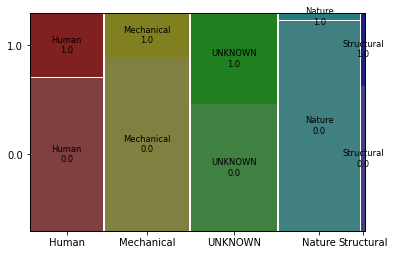

In [10]:
mosaic_df = raw_dataset[['CauseCategory', 'Transport Accident']].copy()
mosaic_df['Deaths'] = yDeath

mosaic(data=mosaic_df, index=['CauseCategory', 'Deaths'])
plt.show()

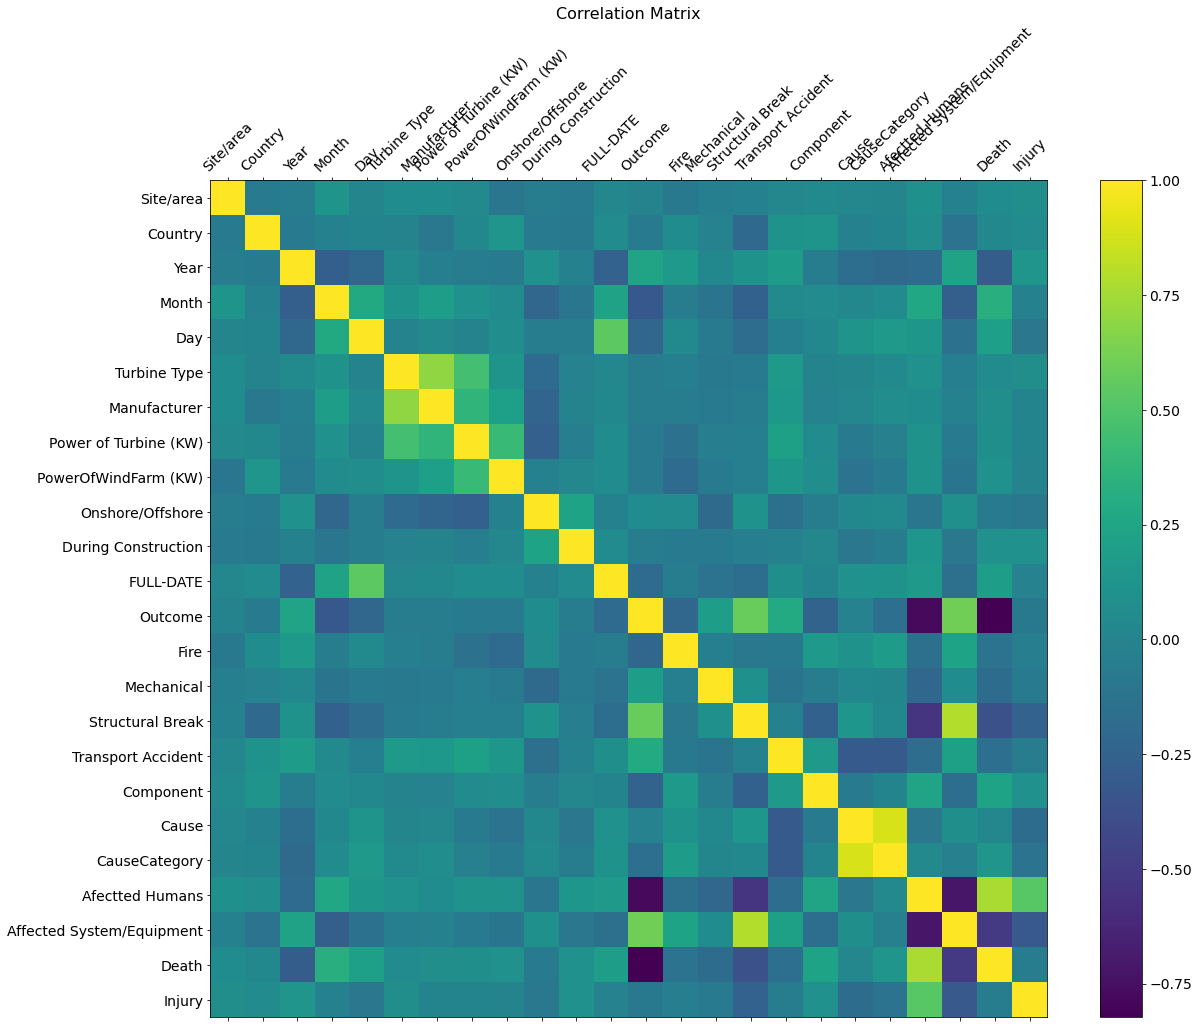

In [11]:
df_corrr = df
df_corrr["Death"] = yDeath
df_corrr["Injury"] = yInjury

cr_mtx = df_corrr.corr()
f = plt.figure(figsize=(19, 15))
plt.matshow(cr_mtx, fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [12]:
upper = cr_mtx.where(np.triu(np.ones(cr_mtx.shape), k=1).astype(np.bool))
cr_mtx = upper.fillna(0)

<ipython-input-12-e56867fb7b22>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = cr_mtx.where(np.triu(np.ones(cr_mtx.shape), k=1).astype(np.bool))


In [13]:
lst = list(cr_mtx.columns.values)
c = []
for i in lst:
    for j in lst:
        if i != j and (cr_mtx[i][j] >= 0.2 or cr_mtx[i][j] <= -0.2) :
            c.append({i,j})

c            

[{'Month', 'Year'},
 {'Day', 'Year'},
 {'Day', 'Month'},
 {'Manufacturer', 'Turbine Type'},
 {'Power of Turbine (KW)', 'Turbine Type'},
 {'Manufacturer', 'Power of Turbine (KW)'},
 {'Manufacturer', 'PowerOfWindFarm (KW)'},
 {'Power of Turbine (KW)', 'PowerOfWindFarm (KW)'},
 {'Month', 'Onshore/Offshore'},
 {'Manufacturer', 'Onshore/Offshore'},
 {'Onshore/Offshore', 'Power of Turbine (KW)'},
 {'During Construction', 'Onshore/Offshore'},
 {'FULL-DATE', 'Year'},
 {'FULL-DATE', 'Month'},
 {'Day', 'FULL-DATE'},
 {'Outcome', 'Year'},
 {'Month', 'Outcome'},
 {'Day', 'Outcome'},
 {'Fire', 'Outcome'},
 {'Month', 'Structural Break'},
 {'Outcome', 'Structural Break'},
 {'Power of Turbine (KW)', 'Transport Accident'},
 {'Outcome', 'Transport Accident'},
 {'Component', 'Outcome'},
 {'Component', 'Structural Break'},
 {'Cause', 'Transport Accident'},
 {'CauseCategory', 'Transport Accident'},
 {'Cause', 'CauseCategory'},
 {'Afectted Humans', 'Month'},
 {'Afectted Humans', 'Outcome'},
 {'Afectted Huma

In [14]:
StatisticalTest = pd.DataFrame(columns=['Test No', 'Attribute1','Attribute2', 'Correlation', 'Test Performed' ,'p-Value', 'Result'])

for x in c :
    #print(x.pop() + "  " + x.pop())
    a = x.pop()
    b =x.pop()
    if  raw_dataset.dtypes[a] == np.object and raw_dataset.dtypes[b] == np.object :
        # Kolmogorov-Smirnov test
        res = stats.ks_2samp(df[a], df[b], alternative='less')
        if res[1] < 0.05 :
            ok = "-"  
        else :
            ok = "+"
        StatisticalTest.loc[len(StatisticalTest)] = [c.index(x) , a , b , cr_mtx[a][b], "K-S Test" , res[1], ok]
        
    elif raw_dataset.dtypes[a] == np.float64 and raw_dataset.dtypes[b] == np.float64 :
        
        dfDropNa = df.dropna()
        
        res = stats.chi2_contingency(pd.crosstab(dfDropNa[a], dfDropNa[b], margins = False))
        if res[1] < 0.05 :
            ok = "-"  
        else :
            ok = "+"
        StatisticalTest.loc[len(StatisticalTest)] = [c.index(x) , a , b , cr_mtx[a][b], "Chi Square Pearson Test" , res[1], ok]
        
    elif (raw_dataset.dtypes[a] == np.float64 and raw_dataset.dtypes[b] == np.object) or (raw_dataset.dtypes[a] == np.object and raw_dataset.dtypes[b] == np.float64):
        dfDropNa = df.dropna()     
        
        res = stats.shapiro(dfDropNa[[a, b]])
        if res[1] < 0.05 : 
            res1 = stats.ttest_ind(dfDropNa[a], dfDropNa[b])
            if res1[1] < 0.05 :
                    ok = "-"  
            else :
                ok = "+"
            StatisticalTest.loc[len(StatisticalTest)] = [c.index(x) , a , b , cr_mtx[a][b], "T-Test" , res[1], ok]
        else :
            res1 = stats.kruskal(dfDropNa[a], dfDropNa[b])
            if res1[1] < 0.05 :
                    ok = "-"  
            else :
                ok = "+"
            StatisticalTest.loc[len(StatisticalTest)] = [c.index(x) , a , b , cr_mtx[a][b], "Kruskal-Wallis Test" , res[1], ok]
    
StatisticalTest.sort_values('Correlation',ascending=[False] )

<ipython-input-14-995f0903266f>:7: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if  raw_dataset.dtypes[a] == np.object and raw_dataset.dtypes[b] == np.object :
<ipython-input-14-995f0903266f>:27: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif (raw_dataset.dtypes[a] == np.float64 and raw_dataset.dtypes[b] == np.object) or (raw_dataset.dtypes[a] == np.object and raw_dataset.dtypes[b] == np.float64):


,Test No,Attribute1,Attribute2,Correlation,Test Performed,p-Value,Result
3,0,Manufacturer,Turbine Type,0.698886,K-S Test,7.214134e-34,-
35,0,Affected System/Equipment,Outcome,0.605040,T-Test,7.453764e-28,-
20,0,Structural Break,Outcome,0.577698,T-Test,4.255842e-27,+
4,0,Power of Turbine (KW),Turbine Type,0.452508,K-S Test,6.921148e-33,-
41,0,Death,Month,0.327516,T-Test,2.382551e-26,-
22,0,Transport Accident,Outcome,0.294711,T-Test,4.049380e-28,-
2,0,Day,Month,0.282018,K-S Test,1.724874e-06,-
28,0,Afectted Humans,Month,0.266614,T-Test,1.243287e-25,-
36,0,Affected System/Equipment,Fire,0.236627,Chi Square Pearson Test,2.113838e-04,-
42,0,Death,Day,0.202599,T-Test,1.300828e-26,-


In [15]:
RankingD = pd.DataFrame(columns=['Attribute', 'Values', 'Information Gain'])
i = 1

for cols in df.columns :
    res = sp.kl_div(df[cols] , yDeath)
    res = [x for x in res if str(x) != 'nan']
    res = [x for x in res if str(x) != 'inf']
    row = {'Attribute':cols, 'Values':max(Counter(res).values()), 'Information Gain':sum(res)/len(res)}
    RankingD = RankingD.append(row, ignore_index= True)
    

RankingD.sort_values('Information Gain', ascending=[False])
#RankingD.sort_index()

,Attribute,Values,Information Gain
12,Outcome,48,0.649163
21,Affected System/Equipment,52,0.469388
15,Structural Break,79,0.373016
14,Mechanical,177,0.265560
18,Cause,43,0.263250
16,Transport Accident,182,0.260163
13,Fire,181,0.255144
23,Injury,185,0.241803
9,Onshore/Offshore,157,0.237456
10,During Construction,201,0.225265


In [16]:
dfD = df[yDeath == 0]
dfD = dfD[[RankingD['Attribute'].iloc[0] , RankingD['Attribute'].iloc[1] , RankingD['Attribute'].iloc[2]
           , RankingD['Attribute'].iloc[3] , RankingD['Attribute'].iloc[4]]]
dfD.rank()


,Site/area,Country,Year,Month,Day
0,176.0,29.0,33.5,51.5,142.5
2,74.5,108.0,120.5,13.5,187.5
3,11.0,108.0,149.0,73.5,154.0
4,122.0,170.0,149.0,132.0,12.0
5,198.0,170.0,92.5,34.0,87.5
...,...,...,...,...,...
266,10.0,108.0,92.5,162.5,187.5
267,171.0,170.0,92.5,162.5,187.5
268,33.0,15.0,92.5,176.0,187.5
271,66.0,170.0,92.5,195.0,109.5


In [17]:
RankingI = pd.DataFrame(columns=['Attribute', 'Values', 'Information Gain'])
i = 1

for cols in df.columns :
    res = sp.kl_div(df[cols] , yInjury)
    res = [x for x in res if str(x) != 'nan']
    res = [x for x in res if str(x) != 'inf']
    row = {'Attribute':cols, 'Values':max(Counter(res).values()), 'Information Gain':sum(res)/len(res)}
    RankingI = RankingI.append(row, ignore_index= True)
    

RankingI.sort_values('Information Gain', ascending=[False])

,Attribute,Values,Information Gain
18,Cause,22,0.316509
21,Affected System/Equipment,68,0.252747
11,FULL-DATE,7,0.222014
19,CauseCategory,55,0.219063
15,Structural Break,93,0.211864
4,Day,15,0.211581
3,Month,30,0.180183
0,Site/area,4,0.179807
12,Outcome,22,0.155684
7,Power of Turbine (KW),24,0.143329


In [18]:
#Split the data into test and train
df = raw_dataset.copy()
df = df.dropna()
yDeath = df['Death']
yInjury = df['Injury']
df = df.drop('Death', axis=1)
df = df.drop('Injury', axis=1)

enc = OrdinalEncoder()
enc.fit(df[["Site/area","Country", "Year", "Month", "Day", "Turbine Type", "Manufacturer", "Power of Turbine (KW)", "PowerOfWindFarm (KW)", "Onshore/Offshore", "During Construction", "FULL-DATE", "Outcome", "Component", "Cause", "CauseCategory"]])
df[["Site/area","Country", "Year", "Month", "Day", "Turbine Type", "Manufacturer", "Power of Turbine (KW)", "PowerOfWindFarm (KW)", "Onshore/Offshore", "During Construction", "FULL-DATE", "Outcome", "Component", "Cause", "CauseCategory"]] = enc.transform(df[["Site/area","Country", "Year", "Month", "Day", "Turbine Type", "Manufacturer", "Power of Turbine (KW)", "PowerOfWindFarm (KW)", "Onshore/Offshore", "During Construction", "FULL-DATE", "Outcome", "Component", "Cause", "CauseCategory"]])
for cols in df.columns :
    df[cols] = (df[cols] - min(df[cols]))/( max(df[cols]) - min(df[cols]))

X_trainD, X_testD, y_trainD, y_testD = train_test_split(df, yDeath, test_size=0.33, random_state=42)
X_trainI, X_testI, y_trainI, y_testI = train_test_split(df, yInjury, test_size=0.33, random_state=42)

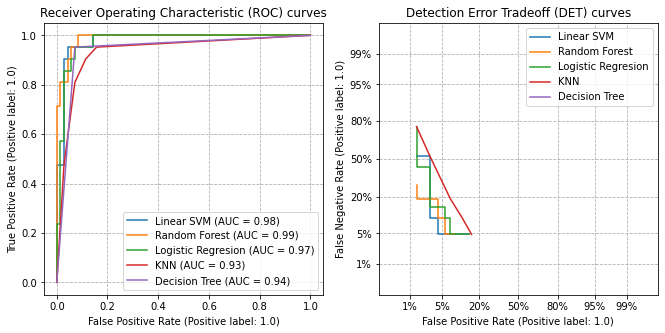

,Classifier,CA,AUC
0,Linear SVM,0.945055,0.947619
2,Logistic Regresion,0.934066,0.940476
4,Decision Tree,0.934066,0.940476
1,Random Forest,0.934066,0.907143
3,KNN,0.901099,0.869048


In [19]:
ClassifiersD = pd.DataFrame(columns=['Classifier', 'CA', 'AUC'])

classifiers = {
    "Linear SVM": make_pipeline(StandardScaler(), LinearSVC(C=0.025)),
    "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    "Logistic Regresion" : LogisticRegression(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": tree.DecisionTreeClassifier()
}

# prepare plots
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, clf in classifiers.items():
    clf.fit(X_trainD, y_trainD)
    score = accuracy_score(y_testD, clf.predict(X_testD))
    roc = roc_auc_score(y_testD, clf.predict(X_testD))
    row = {'Classifier': name, 'CA':score, 'AUC':roc}
    ClassifiersD = ClassifiersD.append(row, ignore_index= True)

    RocCurveDisplay.from_estimator(clf, X_testD, y_testD, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_testD, y_testD, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()
ClassifiersD.sort_values('AUC',ascending=[False])

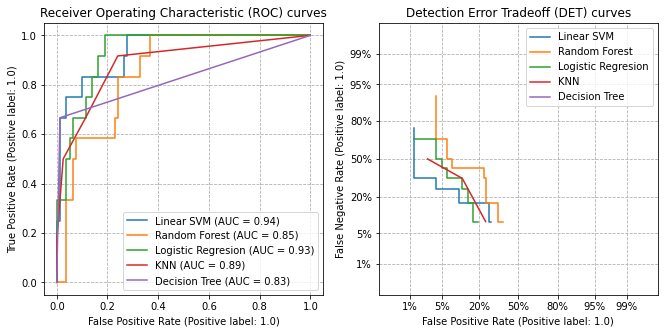

,Classifier,CA,AUC
4,Decision Tree,0.945055,0.827004
3,KNN,0.912088,0.737342
0,Linear SVM,0.912088,0.702004
2,Logistic Regresion,0.901099,0.625000
1,Random Forest,0.868132,0.500000


In [20]:
ClassifiersI = pd.DataFrame(columns=['Classifier', 'CA', 'AUC'])

classifiers = {
    "Linear SVM": make_pipeline(StandardScaler(), LinearSVC(C=0.025)),
    "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    "Logistic Regresion" : LogisticRegression(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": tree.DecisionTreeClassifier()
}

# prepare plots
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, clf in classifiers.items():
    clf.fit(X_trainI, y_trainI)
    score = accuracy_score(y_testI, clf.predict(X_testI))
    roc = roc_auc_score(y_testI, clf.predict(X_testI))
    row = {'Classifier': name, 'CA':score, 'AUC':roc}
    ClassifiersI = ClassifiersI.append(row, ignore_index= True)

    RocCurveDisplay.from_estimator(clf, X_testI, y_testI, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_testI, y_testI, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()
ClassifiersI.sort_values('AUC',ascending=[False])

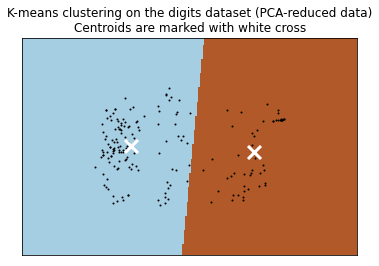

In [21]:
(n_samples, n_features), n_digits = X_trainD.shape, np.unique(y_trainD).size

reduced_data = PCA(n_components=2).fit_transform(X_trainD)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)
labels_kmeans = kmeans.labels_

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

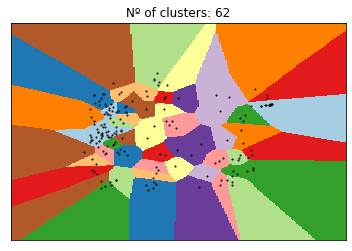

In [22]:
(n_samples, n_features), n_digits = X_trainD.shape, np.unique(y_trainD).size

reduced_data = PCA(n_components=2).fit_transform(X_trainD)

bandwidth = estimate_bandwidth(reduced_data, quantile=0.02, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(reduced_data)
labels_meanshift = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels_meanshift)
n_clusters_ = len(labels_unique)


# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = ms.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)

plt.title(
    "Nº of clusters: "+str(n_clusters_)
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

## Overfitting

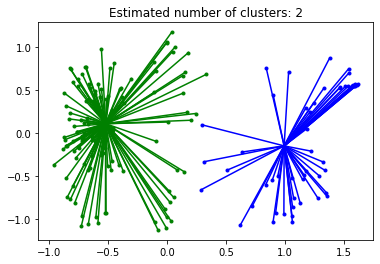

0.3844695936156037


In [23]:
(n_samples, n_features), n_digits = X_trainD.shape, np.unique(y_trainD).size

reduced_data = PCA(n_components=2).fit_transform(X_trainD)

bandwidth = estimate_bandwidth(reduced_data, quantile=0.2, n_samples=500)

af = AffinityPropagation(preference=-50, random_state=0).fit(reduced_data)
cluster_centers_indices = af.cluster_centers_indices_
labels_affprp = af.labels_

n_clusters_ = len(cluster_centers_indices)

plt.close("all")
plt.figure(1)
plt.clf()

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
for k, col in zip(range(n_clusters_), colors):
    class_members = labels_affprp == k
    cluster_center = reduced_data[cluster_centers_indices[k]]
    plt.plot(reduced_data[class_members, 0], reduced_data[class_members, 1], col + ".")

    for x in reduced_data[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()
print(metrics.silhouette_score(reduced_data, y_trainD, metric='euclidean'))

In [24]:
#print(metrics.silhouette_score(reduced_data, labels, metric='euclidean'))  overlapping
#print(davies_bouldin_score(reduced_data, labels))# (0 to 1) numero de clusters optimos, bajo mejor
#print(metrics.calinski_harabasz_score(reduced_data, labels)) #(0 to ...) clusters poco densos
#metrics.fowlkes_mallows_score(labels_kmeans, y_trainD) # calidad del clustering mas alto mejor

ClustersD = pd.DataFrame(columns=['Cluster', 'Fowlkes Mallows','Calinski Harabasz','Silhouette', 'Davies Bouldin'])

row = {'Cluster':"K-means", 'Fowlkes Mallows':metrics.fowlkes_mallows_score(labels_kmeans, y_trainD),'Silhouette':metrics.silhouette_score(reduced_data, labels_kmeans, metric='euclidean'), 'Davies Bouldin':davies_bouldin_score(reduced_data, labels_kmeans), 'Calinski Harabasz':metrics.calinski_harabasz_score(reduced_data, labels_kmeans)}
ClustersD = ClustersD.append(row, ignore_index= True)
row = {'Cluster':"Means Shift", 'Fowlkes Mallows':metrics.fowlkes_mallows_score(labels_meanshift, y_trainD),'Silhouette':metrics.silhouette_score(reduced_data, labels_meanshift, metric='euclidean'), 'Davies Bouldin':davies_bouldin_score(reduced_data, labels_meanshift), 'Calinski Harabasz':metrics.calinski_harabasz_score(reduced_data, labels_meanshift)}
ClustersD = ClustersD.append(row, ignore_index= True)
row = {'Cluster':"Affinity Propagation", 'Fowlkes Mallows':metrics.fowlkes_mallows_score(labels_affprp, y_trainD),'Silhouette':metrics.silhouette_score(reduced_data, labels_affprp, metric='euclidean'), 'Davies Bouldin':davies_bouldin_score(reduced_data, labels_affprp), 'Calinski Harabasz':metrics.calinski_harabasz_score(reduced_data, labels_affprp)}
ClustersD = ClustersD.append(row, ignore_index= True)


ClustersD

,Cluster,Fowlkes Mallows,Calinski Harabasz,Silhouette,Davies Bouldin
0,K-means,0.793070,234.650805,0.552491,0.724553
1,Means Shift,0.192671,541.092385,0.372169,0.436201
2,Affinity Propagation,0.797480,232.893112,0.543947,0.741494


In [25]:
print("K-Means info:")
print(classification_report(y_trainD, labels_kmeans, labels=[0, 1]))
print("Mean Shift info:")
print(classification_report(y_trainD, labels_meanshift, labels=[0, 1]))
print("Affinity propagation info:")
print(classification_report(y_trainD, labels_affprp, labels=[0, 1]))

K-Means info:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       138
           1       0.67      0.77      0.72        44

    accuracy                           0.85       182
   macro avg       0.80      0.82      0.81       182
weighted avg       0.86      0.85      0.86       182

Mean Shift info:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     138.0
           1       0.00      0.00      0.00      44.0

   micro avg       0.00      0.00      0.00     182.0
   macro avg       0.00      0.00      0.00     182.0
weighted avg       0.00      0.00      0.00     182.0

Affinity propagation info:
              precision    recall  f1-score   support

           0       0.33      0.13      0.19       138
           1       0.06      0.18      0.09        44

    accuracy                           0.14       182
   macro avg       0.20      0.16      0.14       182
weighted avg    

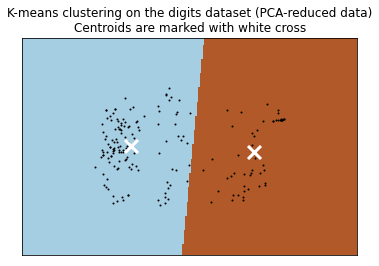

In [26]:
(n_samples, n_features), n_digits = X_trainD.shape, np.unique(y_trainI).size

reduced_data = PCA(n_components=2).fit_transform(X_trainI)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)
labels_kmeans = kmeans.labels_

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

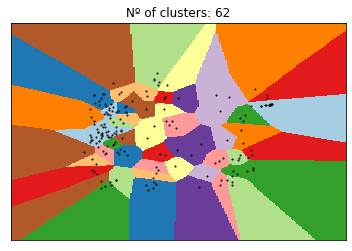

In [27]:
(n_samples, n_features), n_digits = X_trainI.shape, np.unique(y_trainI).size

reduced_data = PCA(n_components=2).fit_transform(X_trainI)

bandwidth = estimate_bandwidth(reduced_data, quantile=0.02, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(reduced_data)
labels_meanshift = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels_meanshift)
n_clusters_ = len(labels_unique)


# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = ms.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)

plt.title(
    "Nº of clusters: "+str(n_clusters_)
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

## Overfitting

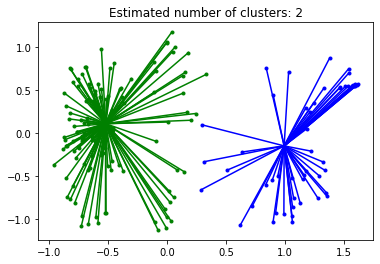

0.3844695936156037


In [28]:
(n_samples, n_features), n_digits = X_trainI.shape, np.unique(y_trainI).size

reduced_data = PCA(n_components=2).fit_transform(X_trainI)

bandwidth = estimate_bandwidth(reduced_data, quantile=0.2, n_samples=500)

af = AffinityPropagation(preference=-50, random_state=0).fit(reduced_data)
cluster_centers_indices = af.cluster_centers_indices_
labels_affprp = af.labels_

n_clusters_ = len(cluster_centers_indices)

plt.close("all")
plt.figure(1)
plt.clf()

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
for k, col in zip(range(n_clusters_), colors):
    class_members = labels_affprp == k
    cluster_center = reduced_data[cluster_centers_indices[k]]
    plt.plot(reduced_data[class_members, 0], reduced_data[class_members, 1], col + ".")

    for x in reduced_data[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()
print(metrics.silhouette_score(reduced_data, y_trainD, metric='euclidean'))

In [29]:
#print(metrics.silhouette_score(reduced_data, labels, metric='euclidean'))  overlapping
#print(davies_bouldin_score(reduced_data, labels))# (0 to 1) numero de clusters optimos, bajo mejor
#print(metrics.calinski_harabasz_score(reduced_data, labels)) #(0 to ...) clusters poco densos
#metrics.fowlkes_mallows_score(labels_kmeans, y_trainD) # calidad del clustering mas alto mejor

ClustersI = pd.DataFrame(columns=['Cluster', 'Fowlkes Mallows','Calinski Harabasz','Silhouette', 'Davies Bouldin'])

row = {'Cluster':"K-means", 'Fowlkes Mallows':metrics.fowlkes_mallows_score(labels_kmeans, y_trainI),'Silhouette':metrics.silhouette_score(reduced_data, labels_kmeans, metric='euclidean'), 'Davies Bouldin':davies_bouldin_score(reduced_data, labels_kmeans), 'Calinski Harabasz':metrics.calinski_harabasz_score(reduced_data, labels_kmeans)}
ClustersI = ClustersD.append(row, ignore_index= True)
row = {'Cluster':"Means Shift", 'Fowlkes Mallows':metrics.fowlkes_mallows_score(labels_meanshift, y_trainI),'Silhouette':metrics.silhouette_score(reduced_data, labels_meanshift, metric='euclidean'), 'Davies Bouldin':davies_bouldin_score(reduced_data, labels_meanshift), 'Calinski Harabasz':metrics.calinski_harabasz_score(reduced_data, labels_meanshift)}
ClustersI = ClustersD.append(row, ignore_index= True)
row = {'Cluster':"Affinity Propagation", 'Fowlkes Mallows':metrics.fowlkes_mallows_score(labels_affprp, y_trainI),'Silhouette':metrics.silhouette_score(reduced_data, labels_affprp, metric='euclidean'), 'Davies Bouldin':davies_bouldin_score(reduced_data, labels_affprp), 'Calinski Harabasz':metrics.calinski_harabasz_score(reduced_data, labels_affprp)}
ClustersI = ClustersD.append(row, ignore_index= True)


ClustersI

,Cluster,Fowlkes Mallows,Calinski Harabasz,Silhouette,Davies Bouldin
0,K-means,0.793070,234.650805,0.552491,0.724553
1,Means Shift,0.192671,541.092385,0.372169,0.436201
2,Affinity Propagation,0.797480,232.893112,0.543947,0.741494
3,Affinity Propagation,0.740729,232.893112,0.543947,0.741494


In [30]:
print("K-Means info:")
print(classification_report(y_trainI, labels_kmeans, labels=[0, 1]))
print("Mean Shift info:")
print(classification_report(y_trainI, labels_meanshift, labels=[0, 1]))
print("Affinity propagation info:")
print(classification_report(y_trainI, labels_affprp, labels=[0, 1]))

K-Means info:
              precision    recall  f1-score   support

           0       0.95      0.78      0.86       159
           1       0.31      0.70      0.43        23

    accuracy                           0.77       182
   macro avg       0.63      0.74      0.64       182
weighted avg       0.87      0.77      0.80       182

Mean Shift info:
              precision    recall  f1-score   support

           0       1.00      0.09      0.16       159
           1       0.00      0.00      0.00        23

   micro avg       0.50      0.08      0.13       182
   macro avg       0.50      0.04      0.08       182
weighted avg       0.87      0.08      0.14       182

Affinity propagation info:
              precision    recall  f1-score   support

           0       0.69      0.23      0.35       159
           1       0.05      0.26      0.08        23

    accuracy                           0.24       182
   macro avg       0.37      0.25      0.21       182
weighted avg    

In [31]:
rankD = pd.DataFrame(columns=['Feature', 'Rank'])


rf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
rf.fit(X_trainD, y_trainD)

for cl in X_trainD.columns:
    row = {'Feature': cl, 'Rank': rf.feature_importances_[X_trainD.columns.get_loc(cl)]}
    rankD = rankD.append(row, ignore_index=True)

#The higher, the more important the feature. 
#The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. 
#It is also known as the Gini importance.
rankD.sort_values('Rank', ascending=[False])

,Feature,Rank
20,Afectted Humans,0.194281
12,Outcome,0.158799
21,Affected System/Equipment,0.122420
11,FULL-DATE,0.082311
17,Component,0.078889
4,Day,0.062665
2,Year,0.054947
0,Site/area,0.047496
18,Cause,0.033260
5,Turbine Type,0.032606


In [48]:
ExploratoryD = pd.DataFrame()


df_expD = raw_dataset.dropna()
df_expD = df_expD.drop(df_expD.Injury)
df_expD = df_expD.drop(df_expD[df_expD.Death == 0].index)

n = 8
for a , b in rankD[:10].iterrows():
    if len(df_expD[b["Feature"]].value_counts()[:n].index.tolist()) == 8:
        ExploratoryD[b["Feature"]] = df_expD[b["Feature"]].value_counts()[:n].index.tolist()
    
ExploratoryD

,Site/area,Country,Year,Month,Day,Turbine Type,Manufacturer,Power of Turbine (KW),PowerOfWindFarm (KW)
0,UNKNOWN,USA,2012,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN
1,"Palm Springs, California",Germany,2011,8,22,NEG Micon 1500 KW,Vestas,2500,37500
2,Minnesota,China,2003,5,16,Vestas 2000 KW,Siemens,1500,44000
3,Oregon,UK,2007,10,7,Nordex 2500 KW,Sinovel,2000,49500 KW
4,Iowa,UNKNOWN,1997,11,9,Sinovel,Clipper,1750,5000
5,North Dakota,Australia,2008,1,1,Clipper 2500 KW,Micon,1500 KW,900
6,Illinois,Denmark,1984,7,11,Siemens 2300 KW,Nordex,600,404000 KW
7,Tasmania,Brazil,1993,2,25,Vestas 1800 KW,Enercon,2500 KW,101200


In [33]:
rankI = pd.DataFrame(columns=['Feature', 'Rank'])


rf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
rf.fit(X_trainI, y_trainI)

for cl in X_trainD.columns:
    row = {'Feature': cl, 'Rank': rf.feature_importances_[X_trainD.columns.get_loc(cl)]}
    rankI = rankI.append(row, ignore_index=True)

#The higher, the more important the feature. 
#The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. 
#It is also known as the Gini importance.
rankI.sort_values('Rank', ascending=[False])

,Feature,Rank
0,Site/area,0.144986
20,Afectted Humans,0.113944
12,Outcome,0.103066
2,Year,0.083135
21,Affected System/Equipment,0.081120
11,FULL-DATE,0.058456
7,Power of Turbine (KW),0.056236
6,Manufacturer,0.049946
1,Country,0.043895
18,Cause,0.042492


In [49]:
ExploratoryI = pd.DataFrame()


df_expI = raw_dataset.dropna()
df_expI = df_expI.drop(df_expI.Death)
df_expI = df_expI.drop(df_expI[df_expI.Injury == 0].index)

n = 8
for a , b in rankI[:10].iterrows():
    if len(df_expI[b["Feature"]].value_counts()[:n].index.tolist()) == 8:
        ExploratoryI[b["Feature"]] = df_expI[b["Feature"]].value_counts()[:n].index.tolist()
    
ExploratoryI

,Site/area,Country,Year,Month,Day,Turbine Type,Manufacturer,Power of Turbine (KW),PowerOfWindFarm (KW)
0,Texas,USA,2012,11,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN
1,Pennsylvania,UK,2008,10,20,Vestas 3000 KW,Vestas,2000,60000
2,"Winnebago County, Illinois",Australia,2011,4,14,Siemens 2300 KW,Gamesa,1500,420000
3,Oregon,China,2007,7,23,BWC Excel 10 KW,Siemens,2300,420000 KW
4,Bakersfield,Greece,2009,8,15,Kenetech 100 KW,BWC,10 KW,20000
5,Aberystwyth,Spain,2006,UNKNOWN,21,Gamesa 2000 KW,Kenetech,100,50000
6,Pembrokeshire,Germany,2010,2,9,Siemens 1500 KW,Ming Yang,3000,101200
7,Minnesota,New Zealand,2005,1,25,Ming Yang 1500 KW,Enron,3000 KW,80000


In [35]:
## Sequential

model = Sequential()
model.add(Dense(units=4, activation='relu', input_dim=len(X_trainD.columns)))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer = 'rmsprop',loss = 'categorical_crossentropy', metrics = 'accuracy')
historyD = model.fit(X_trainD, y_trainD,epochs=400, batch_size=128,validation_data=(X_testD,y_testD))

Epoch 1/400
2/2 [==============================] - 1s 164ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 2/400
2/2 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 3/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 4/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 5/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 6/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 7/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_los

2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 57/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 58/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 59/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 60/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 61/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 62/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.00

Epoch 111/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 112/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 113/400
2/2 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 114/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 115/400
2/2 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 116/400
2/2 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 117/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7

2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 166/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 167/400
2/2 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 168/400
2/2 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 169/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 170/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 171/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss

Epoch 220/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 221/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 222/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 223/400
2/2 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 224/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 225/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 226/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7

2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 275/400
2/2 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 276/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 277/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 278/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 279/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 280/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss

Epoch 329/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 330/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 331/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 332/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 333/400
2/2 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 334/400
2/2 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 335/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7

2/2 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 384/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 385/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 386/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 387/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 388/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss: 0.0000e+00 - val_accuracy: 0.7692
Epoch 389/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.7582 - val_loss

3/3 - 0s - loss: 0.0000e+00 - accuracy: 0.7692 - 15ms/epoch - 5ms/step
Loss: 0.0 Accurracy: 0.7692307829856873


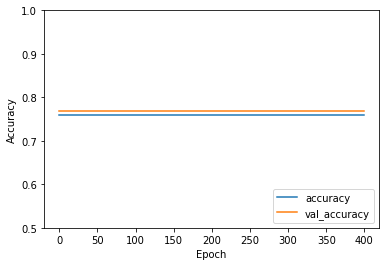

In [36]:
plt.plot(historyD.history['accuracy'], label='accuracy')
plt.plot(historyD.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
## Accurracy
test_lossSD, test_accSD = model.evaluate(X_testD, y_testD, verbose=2)
print("Loss: "+str(test_lossSD)+" Accurracy: "+str(test_accSD))

In [37]:
## Functional

## Creating the layers
input_layer = Input(shape=(len(X_trainD.columns),))
Layer_1 = Dense(4, activation="relu")(input_layer)
Layer_2 = Dense(8, activation="relu")(Layer_1)
output_layer= Dense(1, activation="sigmoid")(Layer_2)

##Defining the model by specifying the input and output layers
model2 = Model(inputs=input_layer, outputs=output_layer)

## defining the optimiser and loss function
model2.compile(optimizer='adam',loss='mse',metrics = 'accuracy')

## training the model
historyD2 = model2.fit(X_trainD, y_trainD,epochs=400, batch_size=128,validation_data=(X_testD,y_testD))

Epoch 1/400
2/2 [==============================] - 0s 101ms/step - loss: 0.2696 - accuracy: 0.4341 - val_loss: 0.2841 - val_accuracy: 0.4176
Epoch 2/400
2/2 [==============================] - 0s 16ms/step - loss: 0.2636 - accuracy: 0.4725 - val_loss: 0.2783 - val_accuracy: 0.4396
Epoch 3/400
2/2 [==============================] - 0s 18ms/step - loss: 0.2581 - accuracy: 0.5110 - val_loss: 0.2729 - val_accuracy: 0.5165
Epoch 4/400
2/2 [==============================] - 0s 18ms/step - loss: 0.2531 - accuracy: 0.5604 - val_loss: 0.2679 - val_accuracy: 0.5714
Epoch 5/400
2/2 [==============================] - 0s 17ms/step - loss: 0.2486 - accuracy: 0.5824 - val_loss: 0.2634 - val_accuracy: 0.5934
Epoch 6/400
2/2 [==============================] - 0s 19ms/step - loss: 0.2442 - accuracy: 0.6099 - val_loss: 0.2591 - val_accuracy: 0.5934
Epoch 7/400
2/2 [==============================] - 0s 17ms/step - loss: 0.2405 - accuracy: 0.6429 - val_loss: 0.2551 - val_accuracy: 0.6374
Epoch 8/400
2/2 [==

2/2 [==============================] - 0s 17ms/step - loss: 0.1222 - accuracy: 0.8736 - val_loss: 0.1497 - val_accuracy: 0.8022
Epoch 60/400
2/2 [==============================] - 0s 16ms/step - loss: 0.1206 - accuracy: 0.8736 - val_loss: 0.1484 - val_accuracy: 0.8022
Epoch 61/400
2/2 [==============================] - 0s 17ms/step - loss: 0.1189 - accuracy: 0.8736 - val_loss: 0.1472 - val_accuracy: 0.8022
Epoch 62/400
2/2 [==============================] - 0s 17ms/step - loss: 0.1173 - accuracy: 0.8736 - val_loss: 0.1461 - val_accuracy: 0.8022
Epoch 63/400
2/2 [==============================] - 0s 17ms/step - loss: 0.1157 - accuracy: 0.8736 - val_loss: 0.1449 - val_accuracy: 0.8022
Epoch 64/400
2/2 [==============================] - 0s 16ms/step - loss: 0.1143 - accuracy: 0.8736 - val_loss: 0.1438 - val_accuracy: 0.8022
Epoch 65/400
2/2 [==============================] - 0s 16ms/step - loss: 0.1128 - accuracy: 0.8736 - val_loss: 0.1427 - val_accuracy: 0.8022
Epoch 66/400
2/2 [========

2/2 [==============================] - 0s 18ms/step - loss: 0.0720 - accuracy: 0.9066 - val_loss: 0.1102 - val_accuracy: 0.8462
Epoch 118/400
2/2 [==============================] - 0s 18ms/step - loss: 0.0715 - accuracy: 0.9176 - val_loss: 0.1097 - val_accuracy: 0.8242
Epoch 119/400
2/2 [==============================] - 0s 18ms/step - loss: 0.0710 - accuracy: 0.9176 - val_loss: 0.1093 - val_accuracy: 0.8242
Epoch 120/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0705 - accuracy: 0.9231 - val_loss: 0.1089 - val_accuracy: 0.8242
Epoch 121/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0701 - accuracy: 0.9231 - val_loss: 0.1085 - val_accuracy: 0.8242
Epoch 122/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0697 - accuracy: 0.9231 - val_loss: 0.1081 - val_accuracy: 0.8242
Epoch 123/400
2/2 [==============================] - 0s 18ms/step - loss: 0.0692 - accuracy: 0.9231 - val_loss: 0.1077 - val_accuracy: 0.8242
Epoch 124/400
2/2 [=

Epoch 175/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0500 - accuracy: 0.9560 - val_loss: 0.0884 - val_accuracy: 0.8462
Epoch 176/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0497 - accuracy: 0.9560 - val_loss: 0.0881 - val_accuracy: 0.8462
Epoch 177/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0495 - accuracy: 0.9560 - val_loss: 0.0878 - val_accuracy: 0.8571
Epoch 178/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0491 - accuracy: 0.9560 - val_loss: 0.0875 - val_accuracy: 0.8571
Epoch 179/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0488 - accuracy: 0.9560 - val_loss: 0.0871 - val_accuracy: 0.8681
Epoch 180/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0486 - accuracy: 0.9505 - val_loss: 0.0868 - val_accuracy: 0.8681
Epoch 181/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0483 - accuracy: 0.9505 - val_loss: 0.0865 - val_accuracy: 0.8791
Epoch 

Epoch 233/400
2/2 [==============================] - 0s 18ms/step - loss: 0.0361 - accuracy: 0.9725 - val_loss: 0.0735 - val_accuracy: 0.8901
Epoch 234/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0358 - accuracy: 0.9725 - val_loss: 0.0732 - val_accuracy: 0.8901
Epoch 235/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0356 - accuracy: 0.9725 - val_loss: 0.0730 - val_accuracy: 0.8901
Epoch 236/400
2/2 [==============================] - 0s 18ms/step - loss: 0.0354 - accuracy: 0.9725 - val_loss: 0.0728 - val_accuracy: 0.8901
Epoch 237/400
2/2 [==============================] - 0s 14ms/step - loss: 0.0352 - accuracy: 0.9725 - val_loss: 0.0726 - val_accuracy: 0.8901
Epoch 238/400
2/2 [==============================] - 0s 18ms/step - loss: 0.0350 - accuracy: 0.9725 - val_loss: 0.0724 - val_accuracy: 0.9011
Epoch 239/400
2/2 [==============================] - 0s 18ms/step - loss: 0.0348 - accuracy: 0.9725 - val_loss: 0.0722 - val_accuracy: 0.9121
Epoch 

Epoch 291/400
2/2 [==============================] - 0s 18ms/step - loss: 0.0269 - accuracy: 0.9835 - val_loss: 0.0633 - val_accuracy: 0.9011
Epoch 292/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0267 - accuracy: 0.9835 - val_loss: 0.0632 - val_accuracy: 0.9011
Epoch 293/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0266 - accuracy: 0.9835 - val_loss: 0.0631 - val_accuracy: 0.9121
Epoch 294/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0264 - accuracy: 0.9835 - val_loss: 0.0630 - val_accuracy: 0.9121
Epoch 295/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0263 - accuracy: 0.9835 - val_loss: 0.0629 - val_accuracy: 0.9231
Epoch 296/400
2/2 [==============================] - 0s 15ms/step - loss: 0.0262 - accuracy: 0.9835 - val_loss: 0.0628 - val_accuracy: 0.9231
Epoch 297/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0260 - accuracy: 0.9835 - val_loss: 0.0626 - val_accuracy: 0.9231
Epoch 

Epoch 349/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0206 - accuracy: 0.9890 - val_loss: 0.0567 - val_accuracy: 0.9341
Epoch 350/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0205 - accuracy: 0.9890 - val_loss: 0.0565 - val_accuracy: 0.9341
Epoch 351/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0204 - accuracy: 0.9890 - val_loss: 0.0564 - val_accuracy: 0.9341
Epoch 352/400
2/2 [==============================] - 0s 18ms/step - loss: 0.0204 - accuracy: 0.9890 - val_loss: 0.0563 - val_accuracy: 0.9341
Epoch 353/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0203 - accuracy: 0.9890 - val_loss: 0.0562 - val_accuracy: 0.9341
Epoch 354/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0202 - accuracy: 0.9890 - val_loss: 0.0563 - val_accuracy: 0.9341
Epoch 355/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0201 - accuracy: 0.9890 - val_loss: 0.0563 - val_accuracy: 0.9341
Epoch 

3/3 - 0s - loss: 0.0526 - accuracy: 0.9341 - 14ms/epoch - 5ms/step
Loss: 0.05258283019065857 Accurracy: 0.9340659379959106


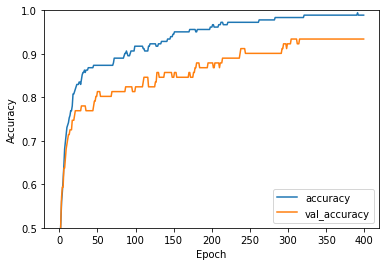

In [38]:
plt.plot(historyD2.history['accuracy'], label='accuracy')
plt.plot(historyD2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
## Accurracy
test_lossFD, test_accFD = model2.evaluate(X_testD, y_testD, verbose=2)
print("Loss: "+str(test_lossFD)+" Accurracy: "+str(test_accFD))

In [39]:
NND = pd.DataFrame(columns=['Neural Network', 'Accuracy', "loss"])

NND = NND.append({"Neural Network":"Sequential", "Accuracy":test_accSD , "loss":test_lossSD }, ignore_index= True)
NND = NND.append({"Neural Network":"Functional", "Accuracy":test_accFD , "loss":test_lossFD }, ignore_index= True)

NND

,Neural Network,Accuracy,loss
0,Sequential,0.769231,0.000000
1,Functional,0.934066,0.052583


In [40]:
## Sequential

model = Sequential()
model.add(Dense(units=4, activation='relu', input_dim=len(X_trainI.columns)))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer = 'rmsprop',loss = 'categorical_crossentropy', metrics = 'accuracy')
historyI = model.fit(X_trainI, y_trainI,epochs=400, batch_size=128,validation_data=(X_testI,y_testI))

Epoch 1/400
2/2 [==============================] - 0s 110ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 2/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 3/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 4/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 5/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 6/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 7/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_los

2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 57/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 58/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 59/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 60/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 61/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 62/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.00

Epoch 111/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 112/400
2/2 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 113/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 114/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 115/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 116/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 117/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8

2/2 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 166/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 167/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 168/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 169/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 170/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 171/400
2/2 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss

Epoch 220/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 221/400
2/2 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 222/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 223/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 224/400
2/2 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 225/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 226/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8

2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 275/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 276/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 277/400
2/2 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 278/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 279/400
2/2 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 280/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss

Epoch 329/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 330/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 331/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 332/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 333/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 334/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 335/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8

2/2 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 384/400
2/2 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 385/400
2/2 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 386/400
2/2 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 387/400
2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 388/400
2/2 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss: 0.0000e+00 - val_accuracy: 0.8681
Epoch 389/400
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 0.8736 - val_loss

3/3 - 0s - loss: 0.1851 - accuracy: 0.7473 - 16ms/epoch - 5ms/step
Loss: 0.1850668340921402 Accurracy: 0.7472527623176575


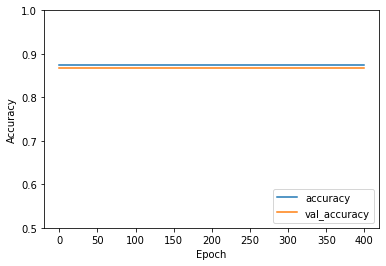

In [41]:
plt.plot(historyI.history['accuracy'], label='accuracy')
plt.plot(historyI.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

## Accurracy
test_lossSI, test_accSI = model2.evaluate(X_testI, y_testI, verbose=2)
print("Loss: "+str(test_lossSI)+" Accurracy: "+str(test_accSI))

In [42]:
## Functional

## Creating the layers
input_layer = Input(shape=(len(X_trainI.columns),))
Layer_1 = Dense(4, activation="relu")(input_layer)
Layer_2 = Dense(8, activation="relu")(Layer_1)
output_layer= Dense(1, activation="sigmoid")(Layer_2)

##Defining the model by specifying the input and output layers
model2 = Model(inputs=input_layer, outputs=output_layer)

## defining the optimiser and loss function
model2.compile(optimizer='adam',loss='mse',metrics = 'accuracy')

## training the model
historyI2 = model2.fit(X_trainI, y_trainI,epochs=400, batch_size=128,validation_data=(X_testI,y_testI))

Epoch 1/4000
2/2 [==============================] - 0s 98ms/step - loss: 0.2573 - accuracy: 0.2692 - val_loss: 0.2557 - val_accuracy: 0.2198
Epoch 2/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.2557 - accuracy: 0.2802 - val_loss: 0.2542 - val_accuracy: 0.2527
Epoch 3/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.2543 - accuracy: 0.3022 - val_loss: 0.2528 - val_accuracy: 0.3297
Epoch 4/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.2529 - accuracy: 0.3626 - val_loss: 0.2514 - val_accuracy: 0.4066
Epoch 5/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.2515 - accuracy: 0.4505 - val_loss: 0.2500 - val_accuracy: 0.4725
Epoch 6/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.2502 - accuracy: 0.5604 - val_loss: 0.2487 - val_accuracy: 0.5495
Epoch 7/4000
2/2 [==============================] - 0s 15ms/step - loss: 0.2489 - accuracy: 0.6538 - val_loss: 0.2475 - val_accuracy: 0.6484
Epoch 8/4000


Epoch 59/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1133 - accuracy: 0.8736 - val_loss: 0.1192 - val_accuracy: 0.8681
Epoch 60/4000
2/2 [==============================] - 0s 26ms/step - loss: 0.1114 - accuracy: 0.8736 - val_loss: 0.1174 - val_accuracy: 0.8681
Epoch 61/4000
2/2 [==============================] - 0s 21ms/step - loss: 0.1099 - accuracy: 0.8736 - val_loss: 0.1159 - val_accuracy: 0.8681
Epoch 62/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.1084 - accuracy: 0.8736 - val_loss: 0.1145 - val_accuracy: 0.8681
Epoch 63/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.1072 - accuracy: 0.8736 - val_loss: 0.1132 - val_accuracy: 0.8681
Epoch 64/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.1061 - accuracy: 0.8736 - val_loss: 0.1121 - val_accuracy: 0.8681
Epoch 65/4000
2/2 [==============================] - 0s 14ms/step - loss: 0.1051 - accuracy: 0.8736 - val_loss: 0.1111 - val_accuracy: 0.8681
Epoch 

2/2 [==============================] - 0s 16ms/step - loss: 0.0918 - accuracy: 0.8736 - val_loss: 0.0987 - val_accuracy: 0.8681
Epoch 117/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0917 - accuracy: 0.8736 - val_loss: 0.0986 - val_accuracy: 0.8681
Epoch 118/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0916 - accuracy: 0.8736 - val_loss: 0.0985 - val_accuracy: 0.8681
Epoch 119/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0914 - accuracy: 0.8736 - val_loss: 0.0984 - val_accuracy: 0.8681
Epoch 120/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0913 - accuracy: 0.8736 - val_loss: 0.0983 - val_accuracy: 0.8681
Epoch 121/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0912 - accuracy: 0.8736 - val_loss: 0.0982 - val_accuracy: 0.8681
Epoch 122/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0911 - accuracy: 0.8736 - val_loss: 0.0981 - val_accuracy: 0.8681
Epoch 123/4000

2/2 [==============================] - 0s 10ms/step - loss: 0.0842 - accuracy: 0.8736 - val_loss: 0.0943 - val_accuracy: 0.8681
Epoch 174/4000
2/2 [==============================] - 0s 10ms/step - loss: 0.0841 - accuracy: 0.8736 - val_loss: 0.0943 - val_accuracy: 0.8681
Epoch 175/4000
2/2 [==============================] - 0s 10ms/step - loss: 0.0839 - accuracy: 0.8736 - val_loss: 0.0942 - val_accuracy: 0.8681
Epoch 176/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0838 - accuracy: 0.8736 - val_loss: 0.0942 - val_accuracy: 0.8681
Epoch 177/4000
2/2 [==============================] - 0s 8ms/step - loss: 0.0837 - accuracy: 0.8736 - val_loss: 0.0942 - val_accuracy: 0.8681
Epoch 178/4000
2/2 [==============================] - 0s 9ms/step - loss: 0.0836 - accuracy: 0.8736 - val_loss: 0.0941 - val_accuracy: 0.8681
Epoch 179/4000
2/2 [==============================] - 0s 10ms/step - loss: 0.0834 - accuracy: 0.8736 - val_loss: 0.0941 - val_accuracy: 0.8681
Epoch 180/4000
2

2/2 [==============================] - 0s 17ms/step - loss: 0.0764 - accuracy: 0.8736 - val_loss: 0.0915 - val_accuracy: 0.8681
Epoch 231/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0762 - accuracy: 0.8736 - val_loss: 0.0915 - val_accuracy: 0.8681
Epoch 232/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0760 - accuracy: 0.8736 - val_loss: 0.0914 - val_accuracy: 0.8681
Epoch 233/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0759 - accuracy: 0.8736 - val_loss: 0.0914 - val_accuracy: 0.8681
Epoch 234/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0757 - accuracy: 0.8736 - val_loss: 0.0913 - val_accuracy: 0.8681
Epoch 235/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0755 - accuracy: 0.8736 - val_loss: 0.0912 - val_accuracy: 0.8681
Epoch 236/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0754 - accuracy: 0.8736 - val_loss: 0.0912 - val_accuracy: 0.8681
Epoch 237/4000

2/2 [==============================] - 0s 17ms/step - loss: 0.0636 - accuracy: 0.9121 - val_loss: 0.0880 - val_accuracy: 0.8901
Epoch 288/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0633 - accuracy: 0.9176 - val_loss: 0.0880 - val_accuracy: 0.9011
Epoch 289/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0630 - accuracy: 0.9176 - val_loss: 0.0880 - val_accuracy: 0.9011
Epoch 290/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0627 - accuracy: 0.9231 - val_loss: 0.0881 - val_accuracy: 0.9011
Epoch 291/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0624 - accuracy: 0.9231 - val_loss: 0.0881 - val_accuracy: 0.9011
Epoch 292/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0622 - accuracy: 0.9231 - val_loss: 0.0882 - val_accuracy: 0.9011
Epoch 293/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0619 - accuracy: 0.9231 - val_loss: 0.0882 - val_accuracy: 0.9011
Epoch 294/4000

2/2 [==============================] - 0s 17ms/step - loss: 0.0493 - accuracy: 0.9451 - val_loss: 0.0838 - val_accuracy: 0.8901
Epoch 345/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0491 - accuracy: 0.9505 - val_loss: 0.0838 - val_accuracy: 0.8901
Epoch 346/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0489 - accuracy: 0.9505 - val_loss: 0.0837 - val_accuracy: 0.8901
Epoch 347/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0486 - accuracy: 0.9505 - val_loss: 0.0837 - val_accuracy: 0.8901
Epoch 348/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0484 - accuracy: 0.9505 - val_loss: 0.0837 - val_accuracy: 0.8901
Epoch 349/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0482 - accuracy: 0.9505 - val_loss: 0.0837 - val_accuracy: 0.8901
Epoch 350/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0480 - accuracy: 0.9505 - val_loss: 0.0836 - val_accuracy: 0.8901
Epoch 351/4000

2/2 [==============================] - 0s 16ms/step - loss: 0.0383 - accuracy: 0.9725 - val_loss: 0.0799 - val_accuracy: 0.8901
Epoch 402/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0382 - accuracy: 0.9725 - val_loss: 0.0799 - val_accuracy: 0.8901
Epoch 403/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0380 - accuracy: 0.9725 - val_loss: 0.0799 - val_accuracy: 0.8901
Epoch 404/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0379 - accuracy: 0.9725 - val_loss: 0.0798 - val_accuracy: 0.8901
Epoch 405/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0377 - accuracy: 0.9725 - val_loss: 0.0798 - val_accuracy: 0.8901
Epoch 406/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0375 - accuracy: 0.9725 - val_loss: 0.0798 - val_accuracy: 0.8901
Epoch 407/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0374 - accuracy: 0.9725 - val_loss: 0.0798 - val_accuracy: 0.8791
Epoch 408/4000

2/2 [==============================] - 0s 17ms/step - loss: 0.0301 - accuracy: 0.9780 - val_loss: 0.0766 - val_accuracy: 0.8791
Epoch 459/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0299 - accuracy: 0.9780 - val_loss: 0.0765 - val_accuracy: 0.8791
Epoch 460/4000
2/2 [==============================] - 0s 20ms/step - loss: 0.0298 - accuracy: 0.9780 - val_loss: 0.0764 - val_accuracy: 0.8791
Epoch 461/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0296 - accuracy: 0.9780 - val_loss: 0.0763 - val_accuracy: 0.8791
Epoch 462/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0295 - accuracy: 0.9780 - val_loss: 0.0763 - val_accuracy: 0.8791
Epoch 463/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0294 - accuracy: 0.9780 - val_loss: 0.0762 - val_accuracy: 0.8791
Epoch 464/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0293 - accuracy: 0.9780 - val_loss: 0.0761 - val_accuracy: 0.8791
Epoch 465/4000

2/2 [==============================] - 0s 17ms/step - loss: 0.0234 - accuracy: 0.9780 - val_loss: 0.0736 - val_accuracy: 0.8901
Epoch 516/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0233 - accuracy: 0.9780 - val_loss: 0.0736 - val_accuracy: 0.8901
Epoch 517/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0232 - accuracy: 0.9780 - val_loss: 0.0735 - val_accuracy: 0.8901
Epoch 518/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0231 - accuracy: 0.9780 - val_loss: 0.0734 - val_accuracy: 0.8901
Epoch 519/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0230 - accuracy: 0.9780 - val_loss: 0.0733 - val_accuracy: 0.8901
Epoch 520/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0229 - accuracy: 0.9780 - val_loss: 0.0731 - val_accuracy: 0.8791
Epoch 521/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0228 - accuracy: 0.9835 - val_loss: 0.0730 - val_accuracy: 0.8901
Epoch 522/4000

2/2 [==============================] - 0s 18ms/step - loss: 0.0178 - accuracy: 0.9835 - val_loss: 0.0705 - val_accuracy: 0.9011
Epoch 573/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0178 - accuracy: 0.9835 - val_loss: 0.0705 - val_accuracy: 0.9011
Epoch 574/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0177 - accuracy: 0.9835 - val_loss: 0.0704 - val_accuracy: 0.9011
Epoch 575/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0176 - accuracy: 0.9835 - val_loss: 0.0703 - val_accuracy: 0.9011
Epoch 576/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0175 - accuracy: 0.9835 - val_loss: 0.0700 - val_accuracy: 0.9011
Epoch 577/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0175 - accuracy: 0.9835 - val_loss: 0.0699 - val_accuracy: 0.9011
Epoch 578/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0173 - accuracy: 0.9835 - val_loss: 0.0698 - val_accuracy: 0.9011
Epoch 579/4000

2/2 [==============================] - 0s 17ms/step - loss: 0.0133 - accuracy: 0.9945 - val_loss: 0.0679 - val_accuracy: 0.9011
Epoch 630/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0134 - accuracy: 0.9945 - val_loss: 0.0679 - val_accuracy: 0.9011
Epoch 631/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0132 - accuracy: 0.9945 - val_loss: 0.0676 - val_accuracy: 0.9011
Epoch 632/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0131 - accuracy: 0.9945 - val_loss: 0.0674 - val_accuracy: 0.9011
Epoch 633/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0131 - accuracy: 0.9945 - val_loss: 0.0673 - val_accuracy: 0.9011
Epoch 634/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0130 - accuracy: 0.9945 - val_loss: 0.0672 - val_accuracy: 0.9011
Epoch 635/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0130 - accuracy: 0.9945 - val_loss: 0.0671 - val_accuracy: 0.9011
Epoch 636/4000

2/2 [==============================] - 0s 18ms/step - loss: 0.0100 - accuracy: 0.9945 - val_loss: 0.0658 - val_accuracy: 0.9011
Epoch 687/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0099 - accuracy: 0.9945 - val_loss: 0.0659 - val_accuracy: 0.9011
Epoch 688/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0099 - accuracy: 0.9945 - val_loss: 0.0659 - val_accuracy: 0.9011
Epoch 689/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0099 - accuracy: 0.9945 - val_loss: 0.0657 - val_accuracy: 0.9011
Epoch 690/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0098 - accuracy: 0.9945 - val_loss: 0.0657 - val_accuracy: 0.9011
Epoch 691/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0097 - accuracy: 0.9945 - val_loss: 0.0657 - val_accuracy: 0.9011
Epoch 692/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0097 - accuracy: 0.9945 - val_loss: 0.0656 - val_accuracy: 0.9011
Epoch 693/4000

2/2 [==============================] - 0s 17ms/step - loss: 0.0075 - accuracy: 0.9945 - val_loss: 0.0641 - val_accuracy: 0.9011
Epoch 744/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0074 - accuracy: 0.9945 - val_loss: 0.0642 - val_accuracy: 0.9011
Epoch 745/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0074 - accuracy: 0.9945 - val_loss: 0.0644 - val_accuracy: 0.9011
Epoch 746/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0074 - accuracy: 0.9945 - val_loss: 0.0644 - val_accuracy: 0.9011
Epoch 747/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0073 - accuracy: 0.9945 - val_loss: 0.0644 - val_accuracy: 0.9011
Epoch 748/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0073 - accuracy: 0.9945 - val_loss: 0.0643 - val_accuracy: 0.9011
Epoch 749/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0073 - accuracy: 0.9945 - val_loss: 0.0643 - val_accuracy: 0.9011
Epoch 750/4000

2/2 [==============================] - 0s 18ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0636 - val_accuracy: 0.9231
Epoch 801/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0638 - val_accuracy: 0.9231
Epoch 802/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0638 - val_accuracy: 0.9231
Epoch 803/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0639 - val_accuracy: 0.9121
Epoch 804/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0640 - val_accuracy: 0.9121
Epoch 805/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.0639 - val_accuracy: 0.9121
Epoch 806/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.0639 - val_accuracy: 0.9231
Epoch 807/4000

2/2 [==============================] - 0s 17ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0637 - val_accuracy: 0.9231
Epoch 858/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0638 - val_accuracy: 0.9231
Epoch 859/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0638 - val_accuracy: 0.9231
Epoch 860/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0636 - val_accuracy: 0.9231
Epoch 861/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0634 - val_accuracy: 0.9231
Epoch 862/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0632 - val_accuracy: 0.9231
Epoch 863/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0629 - val_accuracy: 0.9231
Epoch 864/4000

2/2 [==============================] - 0s 17ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0631 - val_accuracy: 0.9231
Epoch 915/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0631 - val_accuracy: 0.9231
Epoch 916/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0630 - val_accuracy: 0.9231
Epoch 917/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0631 - val_accuracy: 0.9231
Epoch 918/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0631 - val_accuracy: 0.9231
Epoch 919/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0632 - val_accuracy: 0.9231
Epoch 920/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0632 - val_accuracy: 0.9231
Epoch 921/4000

2/2 [==============================] - 0s 17ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0632 - val_accuracy: 0.9121
Epoch 972/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0632 - val_accuracy: 0.9121
Epoch 973/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0633 - val_accuracy: 0.9121
Epoch 974/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0633 - val_accuracy: 0.9121
Epoch 975/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0633 - val_accuracy: 0.9121
Epoch 976/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0632 - val_accuracy: 0.9121
Epoch 977/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0631 - val_accuracy: 0.9121
Epoch 978/4000

2/2 [==============================] - 0s 16ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0632 - val_accuracy: 0.9121
Epoch 1029/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0632 - val_accuracy: 0.9121
Epoch 1030/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0632 - val_accuracy: 0.9121
Epoch 1031/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0632 - val_accuracy: 0.9121
Epoch 1032/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0632 - val_accuracy: 0.9121
Epoch 1033/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0632 - val_accuracy: 0.9121
Epoch 1034/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0633 - val_accuracy: 0.9121
Epoch 10

2/2 [==============================] - 0s 17ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0632 - val_accuracy: 0.9121
Epoch 1086/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0633 - val_accuracy: 0.9121
Epoch 1087/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0635 - val_accuracy: 0.9121
Epoch 1088/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0636 - val_accuracy: 0.9121
Epoch 1089/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0636 - val_accuracy: 0.9121
Epoch 1090/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0636 - val_accuracy: 0.9121
Epoch 1091/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0634 - val_accuracy: 0.9121
Epoch 10

2/2 [==============================] - 0s 17ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0634 - val_accuracy: 0.9121
Epoch 1143/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0634 - val_accuracy: 0.9121
Epoch 1144/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0635 - val_accuracy: 0.9121
Epoch 1145/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0635 - val_accuracy: 0.9121
Epoch 1146/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0635 - val_accuracy: 0.9121
Epoch 1147/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0636 - val_accuracy: 0.9121
Epoch 1148/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0636 - val_accuracy: 0.9121
Epoch 11

2/2 [==============================] - 0s 17ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0638 - val_accuracy: 0.9121
Epoch 1200/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0638 - val_accuracy: 0.9121
Epoch 1201/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0637 - val_accuracy: 0.9121
Epoch 1202/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0637 - val_accuracy: 0.9121
Epoch 1203/4000
2/2 [==============================] - 0s 16ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0637 - val_accuracy: 0.9121
Epoch 1204/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0637 - val_accuracy: 0.9121
Epoch 1205/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0637 - val_accuracy: 0.9121
Epoch 12

2/2 [==============================] - 0s 16ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0637 - val_accuracy: 0.9121
Epoch 1257/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0637 - val_accuracy: 0.9121
Epoch 1258/4000
2/2 [==============================] - 0s 18ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0637 - val_accuracy: 0.9121
Epoch 1259/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0637 - val_accuracy: 0.9121
Epoch 1260/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0637 - val_accuracy: 0.9121
Epoch 1261/4000
2/2 [==============================] - 0s 17ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0637 - val_accuracy: 0.9121
Epoch 1262/4000
2/2 [==============================] - 0s 19ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0637 - val_accuracy: 0.9121
Epoch 12

Epoch 1313/4000
2/2 [==============================] - 0s 17ms/step - loss: 9.7169e-04 - accuracy: 1.0000 - val_loss: 0.0639 - val_accuracy: 0.9121
Epoch 1314/4000
2/2 [==============================] - 0s 17ms/step - loss: 9.6846e-04 - accuracy: 1.0000 - val_loss: 0.0639 - val_accuracy: 0.9121
Epoch 1315/4000
2/2 [==============================] - 0s 17ms/step - loss: 9.6531e-04 - accuracy: 1.0000 - val_loss: 0.0640 - val_accuracy: 0.9121
Epoch 1316/4000
2/2 [==============================] - 0s 17ms/step - loss: 9.6933e-04 - accuracy: 1.0000 - val_loss: 0.0640 - val_accuracy: 0.9121
Epoch 1317/4000
2/2 [==============================] - 0s 16ms/step - loss: 9.6524e-04 - accuracy: 1.0000 - val_loss: 0.0640 - val_accuracy: 0.9121
Epoch 1318/4000
2/2 [==============================] - 0s 17ms/step - loss: 9.6316e-04 - accuracy: 1.0000 - val_loss: 0.0640 - val_accuracy: 0.9121
Epoch 1319/4000
2/2 [==============================] - 0s 16ms/step - loss: 9.5961e-04 - accuracy: 1.0000 - val_

2/2 [==============================] - 0s 18ms/step - loss: 8.4650e-04 - accuracy: 1.0000 - val_loss: 0.0641 - val_accuracy: 0.9121
Epoch 1369/4000
2/2 [==============================] - 0s 17ms/step - loss: 8.4480e-04 - accuracy: 1.0000 - val_loss: 0.0641 - val_accuracy: 0.9121
Epoch 1370/4000
2/2 [==============================] - 0s 17ms/step - loss: 8.4187e-04 - accuracy: 1.0000 - val_loss: 0.0641 - val_accuracy: 0.9121
Epoch 1371/4000
2/2 [==============================] - 0s 17ms/step - loss: 8.3947e-04 - accuracy: 1.0000 - val_loss: 0.0641 - val_accuracy: 0.9121
Epoch 1372/4000
2/2 [==============================] - 0s 16ms/step - loss: 8.3704e-04 - accuracy: 1.0000 - val_loss: 0.0641 - val_accuracy: 0.9121
Epoch 1373/4000
2/2 [==============================] - 0s 18ms/step - loss: 8.3392e-04 - accuracy: 1.0000 - val_loss: 0.0640 - val_accuracy: 0.9121
Epoch 1374/4000
2/2 [==============================] - 0s 17ms/step - loss: 8.3166e-04 - accuracy: 1.0000 - val_loss: 0.0640 - v

2/2 [==============================] - 0s 16ms/step - loss: 7.3566e-04 - accuracy: 1.0000 - val_loss: 0.0642 - val_accuracy: 0.9121
Epoch 1424/4000
2/2 [==============================] - 0s 17ms/step - loss: 7.3415e-04 - accuracy: 1.0000 - val_loss: 0.0642 - val_accuracy: 0.9121
Epoch 1425/4000
2/2 [==============================] - 0s 16ms/step - loss: 7.3153e-04 - accuracy: 1.0000 - val_loss: 0.0642 - val_accuracy: 0.9121
Epoch 1426/4000
2/2 [==============================] - 0s 17ms/step - loss: 7.3416e-04 - accuracy: 1.0000 - val_loss: 0.0642 - val_accuracy: 0.9231
Epoch 1427/4000
2/2 [==============================] - 0s 16ms/step - loss: 7.2903e-04 - accuracy: 1.0000 - val_loss: 0.0642 - val_accuracy: 0.9121
Epoch 1428/4000
2/2 [==============================] - 0s 17ms/step - loss: 7.2729e-04 - accuracy: 1.0000 - val_loss: 0.0642 - val_accuracy: 0.9121
Epoch 1429/4000
2/2 [==============================] - 0s 17ms/step - loss: 7.2496e-04 - accuracy: 1.0000 - val_loss: 0.0642 - v

2/2 [==============================] - 0s 18ms/step - loss: 6.4643e-04 - accuracy: 1.0000 - val_loss: 0.0643 - val_accuracy: 0.9231
Epoch 1479/4000
2/2 [==============================] - 0s 17ms/step - loss: 6.4233e-04 - accuracy: 1.0000 - val_loss: 0.0643 - val_accuracy: 0.9231
Epoch 1480/4000
2/2 [==============================] - 0s 17ms/step - loss: 6.4421e-04 - accuracy: 1.0000 - val_loss: 0.0644 - val_accuracy: 0.9231
Epoch 1481/4000
2/2 [==============================] - 0s 18ms/step - loss: 6.4194e-04 - accuracy: 1.0000 - val_loss: 0.0644 - val_accuracy: 0.9231
Epoch 1482/4000
2/2 [==============================] - 0s 22ms/step - loss: 6.3884e-04 - accuracy: 1.0000 - val_loss: 0.0644 - val_accuracy: 0.9231
Epoch 1483/4000
2/2 [==============================] - 0s 18ms/step - loss: 6.3648e-04 - accuracy: 1.0000 - val_loss: 0.0644 - val_accuracy: 0.9231
Epoch 1484/4000
2/2 [==============================] - 0s 17ms/step - loss: 6.3495e-04 - accuracy: 1.0000 - val_loss: 0.0644 - v

2/2 [==============================] - 0s 17ms/step - loss: 5.6753e-04 - accuracy: 1.0000 - val_loss: 0.0645 - val_accuracy: 0.9231
Epoch 1534/4000
2/2 [==============================] - 0s 16ms/step - loss: 5.6532e-04 - accuracy: 1.0000 - val_loss: 0.0644 - val_accuracy: 0.9231
Epoch 1535/4000
2/2 [==============================] - 0s 16ms/step - loss: 5.6431e-04 - accuracy: 1.0000 - val_loss: 0.0644 - val_accuracy: 0.9231
Epoch 1536/4000
2/2 [==============================] - 0s 17ms/step - loss: 5.6217e-04 - accuracy: 1.0000 - val_loss: 0.0644 - val_accuracy: 0.9231
Epoch 1537/4000
2/2 [==============================] - 0s 16ms/step - loss: 5.6084e-04 - accuracy: 1.0000 - val_loss: 0.0644 - val_accuracy: 0.9231
Epoch 1538/4000
2/2 [==============================] - 0s 18ms/step - loss: 5.6032e-04 - accuracy: 1.0000 - val_loss: 0.0644 - val_accuracy: 0.9231
Epoch 1539/4000
2/2 [==============================] - 0s 16ms/step - loss: 5.5825e-04 - accuracy: 1.0000 - val_loss: 0.0643 - v

2/2 [==============================] - 0s 17ms/step - loss: 5.0774e-04 - accuracy: 1.0000 - val_loss: 0.0645 - val_accuracy: 0.9231
Epoch 1589/4000
2/2 [==============================] - 0s 17ms/step - loss: 5.0779e-04 - accuracy: 1.0000 - val_loss: 0.0645 - val_accuracy: 0.9231
Epoch 1590/4000
2/2 [==============================] - 0s 17ms/step - loss: 5.0680e-04 - accuracy: 1.0000 - val_loss: 0.0645 - val_accuracy: 0.9231
Epoch 1591/4000
2/2 [==============================] - 0s 16ms/step - loss: 5.0358e-04 - accuracy: 1.0000 - val_loss: 0.0645 - val_accuracy: 0.9231
Epoch 1592/4000
2/2 [==============================] - 0s 16ms/step - loss: 4.9739e-04 - accuracy: 1.0000 - val_loss: 0.0644 - val_accuracy: 0.9231
Epoch 1593/4000
2/2 [==============================] - 0s 16ms/step - loss: 4.9249e-04 - accuracy: 1.0000 - val_loss: 0.0643 - val_accuracy: 0.9231
Epoch 1594/4000
2/2 [==============================] - 0s 17ms/step - loss: 4.9466e-04 - accuracy: 1.0000 - val_loss: 0.0642 - v

2/2 [==============================] - 0s 17ms/step - loss: 4.4475e-04 - accuracy: 1.0000 - val_loss: 0.0644 - val_accuracy: 0.9231
Epoch 1644/4000
2/2 [==============================] - 0s 17ms/step - loss: 4.4375e-04 - accuracy: 1.0000 - val_loss: 0.0644 - val_accuracy: 0.9231
Epoch 1645/4000
2/2 [==============================] - 0s 17ms/step - loss: 4.4313e-04 - accuracy: 1.0000 - val_loss: 0.0644 - val_accuracy: 0.9231
Epoch 1646/4000
2/2 [==============================] - 0s 17ms/step - loss: 4.4206e-04 - accuracy: 1.0000 - val_loss: 0.0644 - val_accuracy: 0.9231
Epoch 1647/4000
2/2 [==============================] - 0s 16ms/step - loss: 4.4106e-04 - accuracy: 1.0000 - val_loss: 0.0644 - val_accuracy: 0.9231
Epoch 1648/4000
2/2 [==============================] - 0s 16ms/step - loss: 4.3958e-04 - accuracy: 1.0000 - val_loss: 0.0644 - val_accuracy: 0.9231
Epoch 1649/4000
2/2 [==============================] - 0s 17ms/step - loss: 4.3852e-04 - accuracy: 1.0000 - val_loss: 0.0644 - v

2/2 [==============================] - 0s 17ms/step - loss: 3.9554e-04 - accuracy: 1.0000 - val_loss: 0.0644 - val_accuracy: 0.9231
Epoch 1699/4000
2/2 [==============================] - 0s 16ms/step - loss: 3.9498e-04 - accuracy: 1.0000 - val_loss: 0.0644 - val_accuracy: 0.9231
Epoch 1700/4000
2/2 [==============================] - 0s 28ms/step - loss: 3.9431e-04 - accuracy: 1.0000 - val_loss: 0.0644 - val_accuracy: 0.9231
Epoch 1701/4000
2/2 [==============================] - 0s 22ms/step - loss: 3.9429e-04 - accuracy: 1.0000 - val_loss: 0.0644 - val_accuracy: 0.9231
Epoch 1702/4000
2/2 [==============================] - 0s 18ms/step - loss: 3.9295e-04 - accuracy: 1.0000 - val_loss: 0.0644 - val_accuracy: 0.9231
Epoch 1703/4000
2/2 [==============================] - 0s 17ms/step - loss: 3.9139e-04 - accuracy: 1.0000 - val_loss: 0.0644 - val_accuracy: 0.9231
Epoch 1704/4000
2/2 [==============================] - 0s 19ms/step - loss: 3.9034e-04 - accuracy: 1.0000 - val_loss: 0.0644 - v

2/2 [==============================] - 0s 17ms/step - loss: 3.5361e-04 - accuracy: 1.0000 - val_loss: 0.0645 - val_accuracy: 0.9341
Epoch 1754/4000
2/2 [==============================] - 0s 16ms/step - loss: 3.5432e-04 - accuracy: 1.0000 - val_loss: 0.0645 - val_accuracy: 0.9341
Epoch 1755/4000
2/2 [==============================] - 0s 19ms/step - loss: 3.5280e-04 - accuracy: 1.0000 - val_loss: 0.0645 - val_accuracy: 0.9341
Epoch 1756/4000
2/2 [==============================] - 0s 17ms/step - loss: 3.5165e-04 - accuracy: 1.0000 - val_loss: 0.0645 - val_accuracy: 0.9341
Epoch 1757/4000
2/2 [==============================] - 0s 17ms/step - loss: 3.5036e-04 - accuracy: 1.0000 - val_loss: 0.0645 - val_accuracy: 0.9231
Epoch 1758/4000
2/2 [==============================] - 0s 16ms/step - loss: 3.5076e-04 - accuracy: 1.0000 - val_loss: 0.0645 - val_accuracy: 0.9231
Epoch 1759/4000
2/2 [==============================] - 0s 17ms/step - loss: 3.5005e-04 - accuracy: 1.0000 - val_loss: 0.0646 - v

2/2 [==============================] - 0s 17ms/step - loss: 3.2149e-04 - accuracy: 1.0000 - val_loss: 0.0648 - val_accuracy: 0.9231
Epoch 1809/4000
2/2 [==============================] - 0s 16ms/step - loss: 3.1931e-04 - accuracy: 1.0000 - val_loss: 0.0648 - val_accuracy: 0.9231
Epoch 1810/4000
2/2 [==============================] - 0s 17ms/step - loss: 3.1668e-04 - accuracy: 1.0000 - val_loss: 0.0648 - val_accuracy: 0.9231
Epoch 1811/4000
2/2 [==============================] - 0s 17ms/step - loss: 3.1540e-04 - accuracy: 1.0000 - val_loss: 0.0647 - val_accuracy: 0.9231
Epoch 1812/4000
2/2 [==============================] - 0s 17ms/step - loss: 3.1387e-04 - accuracy: 1.0000 - val_loss: 0.0647 - val_accuracy: 0.9341
Epoch 1813/4000
2/2 [==============================] - 0s 17ms/step - loss: 3.1349e-04 - accuracy: 1.0000 - val_loss: 0.0647 - val_accuracy: 0.9341
Epoch 1814/4000
2/2 [==============================] - 0s 17ms/step - loss: 3.1392e-04 - accuracy: 1.0000 - val_loss: 0.0646 - v

2/2 [==============================] - 0s 17ms/step - loss: 2.8641e-04 - accuracy: 1.0000 - val_loss: 0.0646 - val_accuracy: 0.9341
Epoch 1864/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.8471e-04 - accuracy: 1.0000 - val_loss: 0.0646 - val_accuracy: 0.9341
Epoch 1865/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.8361e-04 - accuracy: 1.0000 - val_loss: 0.0647 - val_accuracy: 0.9341
Epoch 1866/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.8284e-04 - accuracy: 1.0000 - val_loss: 0.0647 - val_accuracy: 0.9341
Epoch 1867/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.8158e-04 - accuracy: 1.0000 - val_loss: 0.0647 - val_accuracy: 0.9231
Epoch 1868/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.8205e-04 - accuracy: 1.0000 - val_loss: 0.0647 - val_accuracy: 0.9231
Epoch 1869/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.8090e-04 - accuracy: 1.0000 - val_loss: 0.0647 - v

2/2 [==============================] - 0s 16ms/step - loss: 2.5551e-04 - accuracy: 1.0000 - val_loss: 0.0649 - val_accuracy: 0.9231
Epoch 1919/4000
2/2 [==============================] - 0s 18ms/step - loss: 2.5515e-04 - accuracy: 1.0000 - val_loss: 0.0649 - val_accuracy: 0.9231
Epoch 1920/4000
2/2 [==============================] - 0s 16ms/step - loss: 2.5487e-04 - accuracy: 1.0000 - val_loss: 0.0649 - val_accuracy: 0.9231
Epoch 1921/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.5392e-04 - accuracy: 1.0000 - val_loss: 0.0649 - val_accuracy: 0.9341
Epoch 1922/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.5331e-04 - accuracy: 1.0000 - val_loss: 0.0648 - val_accuracy: 0.9341
Epoch 1923/4000
2/2 [==============================] - 0s 18ms/step - loss: 2.5307e-04 - accuracy: 1.0000 - val_loss: 0.0648 - val_accuracy: 0.9341
Epoch 1924/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.5271e-04 - accuracy: 1.0000 - val_loss: 0.0648 - v

2/2 [==============================] - 0s 17ms/step - loss: 2.3054e-04 - accuracy: 1.0000 - val_loss: 0.0649 - val_accuracy: 0.9341
Epoch 1974/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.3105e-04 - accuracy: 1.0000 - val_loss: 0.0649 - val_accuracy: 0.9341
Epoch 1975/4000
2/2 [==============================] - 0s 18ms/step - loss: 2.2965e-04 - accuracy: 1.0000 - val_loss: 0.0649 - val_accuracy: 0.9341
Epoch 1976/4000
2/2 [==============================] - 0s 18ms/step - loss: 2.2970e-04 - accuracy: 1.0000 - val_loss: 0.0649 - val_accuracy: 0.9341
Epoch 1977/4000
2/2 [==============================] - 0s 19ms/step - loss: 2.2966e-04 - accuracy: 1.0000 - val_loss: 0.0649 - val_accuracy: 0.9341
Epoch 1978/4000
2/2 [==============================] - 0s 18ms/step - loss: 2.2943e-04 - accuracy: 1.0000 - val_loss: 0.0649 - val_accuracy: 0.9341
Epoch 1979/4000
2/2 [==============================] - 0s 18ms/step - loss: 2.2789e-04 - accuracy: 1.0000 - val_loss: 0.0649 - v

2/2 [==============================] - 0s 16ms/step - loss: 2.0880e-04 - accuracy: 1.0000 - val_loss: 0.0650 - val_accuracy: 0.9341
Epoch 2029/4000
2/2 [==============================] - 0s 18ms/step - loss: 2.0842e-04 - accuracy: 1.0000 - val_loss: 0.0650 - val_accuracy: 0.9341
Epoch 2030/4000
2/2 [==============================] - 0s 16ms/step - loss: 2.0797e-04 - accuracy: 1.0000 - val_loss: 0.0650 - val_accuracy: 0.9341
Epoch 2031/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.0750e-04 - accuracy: 1.0000 - val_loss: 0.0650 - val_accuracy: 0.9341
Epoch 2032/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.0707e-04 - accuracy: 1.0000 - val_loss: 0.0650 - val_accuracy: 0.9341
Epoch 2033/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.0691e-04 - accuracy: 1.0000 - val_loss: 0.0650 - val_accuracy: 0.9341
Epoch 2034/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.0639e-04 - accuracy: 1.0000 - val_loss: 0.0650 - v

2/2 [==============================] - 0s 18ms/step - loss: 1.8810e-04 - accuracy: 1.0000 - val_loss: 0.0651 - val_accuracy: 0.9341
Epoch 2084/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.8855e-04 - accuracy: 1.0000 - val_loss: 0.0651 - val_accuracy: 0.9341
Epoch 2085/4000
2/2 [==============================] - 0s 18ms/step - loss: 1.8780e-04 - accuracy: 1.0000 - val_loss: 0.0651 - val_accuracy: 0.9341
Epoch 2086/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.8778e-04 - accuracy: 1.0000 - val_loss: 0.0651 - val_accuracy: 0.9341
Epoch 2087/4000
2/2 [==============================] - 0s 19ms/step - loss: 1.8675e-04 - accuracy: 1.0000 - val_loss: 0.0651 - val_accuracy: 0.9341
Epoch 2088/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.8622e-04 - accuracy: 1.0000 - val_loss: 0.0651 - val_accuracy: 0.9341
Epoch 2089/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.8610e-04 - accuracy: 1.0000 - val_loss: 0.0651 - v

2/2 [==============================] - 0s 17ms/step - loss: 1.7090e-04 - accuracy: 1.0000 - val_loss: 0.0651 - val_accuracy: 0.9341
Epoch 2139/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.7053e-04 - accuracy: 1.0000 - val_loss: 0.0652 - val_accuracy: 0.9341
Epoch 2140/4000
2/2 [==============================] - 0s 18ms/step - loss: 1.7025e-04 - accuracy: 1.0000 - val_loss: 0.0652 - val_accuracy: 0.9341
Epoch 2141/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.6991e-04 - accuracy: 1.0000 - val_loss: 0.0652 - val_accuracy: 0.9341
Epoch 2142/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.6967e-04 - accuracy: 1.0000 - val_loss: 0.0652 - val_accuracy: 0.9341
Epoch 2143/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.6933e-04 - accuracy: 1.0000 - val_loss: 0.0652 - val_accuracy: 0.9341
Epoch 2144/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.6904e-04 - accuracy: 1.0000 - val_loss: 0.0652 - v

2/2 [==============================] - 0s 17ms/step - loss: 1.5563e-04 - accuracy: 1.0000 - val_loss: 0.0653 - val_accuracy: 0.9231
Epoch 2194/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.5450e-04 - accuracy: 1.0000 - val_loss: 0.0653 - val_accuracy: 0.9341
Epoch 2195/4000
2/2 [==============================] - 0s 18ms/step - loss: 1.5469e-04 - accuracy: 1.0000 - val_loss: 0.0652 - val_accuracy: 0.9341
Epoch 2196/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.5425e-04 - accuracy: 1.0000 - val_loss: 0.0652 - val_accuracy: 0.9341
Epoch 2197/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.5426e-04 - accuracy: 1.0000 - val_loss: 0.0652 - val_accuracy: 0.9341
Epoch 2198/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.5499e-04 - accuracy: 1.0000 - val_loss: 0.0651 - val_accuracy: 0.9341
Epoch 2199/4000
2/2 [==============================] - 0s 16ms/step - loss: 1.5527e-04 - accuracy: 1.0000 - val_loss: 0.0651 - v

2/2 [==============================] - 0s 12ms/step - loss: 1.4107e-04 - accuracy: 1.0000 - val_loss: 0.0653 - val_accuracy: 0.9341
Epoch 2249/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.4091e-04 - accuracy: 1.0000 - val_loss: 0.0653 - val_accuracy: 0.9341
Epoch 2250/4000
2/2 [==============================] - 0s 18ms/step - loss: 1.4057e-04 - accuracy: 1.0000 - val_loss: 0.0653 - val_accuracy: 0.9341
Epoch 2251/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.4041e-04 - accuracy: 1.0000 - val_loss: 0.0653 - val_accuracy: 0.9341
Epoch 2252/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.4010e-04 - accuracy: 1.0000 - val_loss: 0.0653 - val_accuracy: 0.9341
Epoch 2253/4000
2/2 [==============================] - 0s 16ms/step - loss: 1.4020e-04 - accuracy: 1.0000 - val_loss: 0.0653 - val_accuracy: 0.9341
Epoch 2254/4000
2/2 [==============================] - 0s 16ms/step - loss: 1.3952e-04 - accuracy: 1.0000 - val_loss: 0.0653 - v

2/2 [==============================] - 0s 17ms/step - loss: 1.2897e-04 - accuracy: 1.0000 - val_loss: 0.0653 - val_accuracy: 0.9341
Epoch 2304/4000
2/2 [==============================] - 0s 16ms/step - loss: 1.2867e-04 - accuracy: 1.0000 - val_loss: 0.0654 - val_accuracy: 0.9341
Epoch 2305/4000
2/2 [==============================] - 0s 16ms/step - loss: 1.2839e-04 - accuracy: 1.0000 - val_loss: 0.0654 - val_accuracy: 0.9341
Epoch 2306/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.2817e-04 - accuracy: 1.0000 - val_loss: 0.0654 - val_accuracy: 0.9341
Epoch 2307/4000
2/2 [==============================] - 0s 16ms/step - loss: 1.2819e-04 - accuracy: 1.0000 - val_loss: 0.0654 - val_accuracy: 0.9231
Epoch 2308/4000
2/2 [==============================] - 0s 16ms/step - loss: 1.2810e-04 - accuracy: 1.0000 - val_loss: 0.0654 - val_accuracy: 0.9231
Epoch 2309/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.2800e-04 - accuracy: 1.0000 - val_loss: 0.0654 - v

2/2 [==============================] - 0s 16ms/step - loss: 1.1799e-04 - accuracy: 1.0000 - val_loss: 0.0654 - val_accuracy: 0.9341
Epoch 2359/4000
2/2 [==============================] - 0s 16ms/step - loss: 1.1799e-04 - accuracy: 1.0000 - val_loss: 0.0654 - val_accuracy: 0.9341
Epoch 2360/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.1761e-04 - accuracy: 1.0000 - val_loss: 0.0654 - val_accuracy: 0.9341
Epoch 2361/4000
2/2 [==============================] - 0s 20ms/step - loss: 1.1734e-04 - accuracy: 1.0000 - val_loss: 0.0655 - val_accuracy: 0.9341
Epoch 2362/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.1711e-04 - accuracy: 1.0000 - val_loss: 0.0655 - val_accuracy: 0.9341
Epoch 2363/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.1689e-04 - accuracy: 1.0000 - val_loss: 0.0655 - val_accuracy: 0.9341
Epoch 2364/4000
2/2 [==============================] - 0s 16ms/step - loss: 1.1682e-04 - accuracy: 1.0000 - val_loss: 0.0655 - v

2/2 [==============================] - 0s 16ms/step - loss: 1.0764e-04 - accuracy: 1.0000 - val_loss: 0.0655 - val_accuracy: 0.9341
Epoch 2414/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.0754e-04 - accuracy: 1.0000 - val_loss: 0.0655 - val_accuracy: 0.9341
Epoch 2415/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.0725e-04 - accuracy: 1.0000 - val_loss: 0.0655 - val_accuracy: 0.9341
Epoch 2416/4000
2/2 [==============================] - 0s 16ms/step - loss: 1.0706e-04 - accuracy: 1.0000 - val_loss: 0.0655 - val_accuracy: 0.9341
Epoch 2417/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.0728e-04 - accuracy: 1.0000 - val_loss: 0.0655 - val_accuracy: 0.9341
Epoch 2418/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.0672e-04 - accuracy: 1.0000 - val_loss: 0.0655 - val_accuracy: 0.9341
Epoch 2419/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.0661e-04 - accuracy: 1.0000 - val_loss: 0.0655 - v

2/2 [==============================] - 0s 17ms/step - loss: 9.8644e-05 - accuracy: 1.0000 - val_loss: 0.0655 - val_accuracy: 0.9231
Epoch 2469/4000
2/2 [==============================] - 0s 17ms/step - loss: 9.8667e-05 - accuracy: 1.0000 - val_loss: 0.0655 - val_accuracy: 0.9231
Epoch 2470/4000
2/2 [==============================] - 0s 16ms/step - loss: 9.8265e-05 - accuracy: 1.0000 - val_loss: 0.0655 - val_accuracy: 0.9231
Epoch 2471/4000
2/2 [==============================] - 0s 16ms/step - loss: 9.8056e-05 - accuracy: 1.0000 - val_loss: 0.0655 - val_accuracy: 0.9231
Epoch 2472/4000
2/2 [==============================] - 0s 17ms/step - loss: 9.7865e-05 - accuracy: 1.0000 - val_loss: 0.0655 - val_accuracy: 0.9231
Epoch 2473/4000
2/2 [==============================] - 0s 16ms/step - loss: 9.7722e-05 - accuracy: 1.0000 - val_loss: 0.0655 - val_accuracy: 0.9231
Epoch 2474/4000
2/2 [==============================] - 0s 17ms/step - loss: 9.7424e-05 - accuracy: 1.0000 - val_loss: 0.0655 - v

2/2 [==============================] - 0s 17ms/step - loss: 9.0130e-05 - accuracy: 1.0000 - val_loss: 0.0655 - val_accuracy: 0.9231
Epoch 2524/4000
2/2 [==============================] - 0s 17ms/step - loss: 8.9931e-05 - accuracy: 1.0000 - val_loss: 0.0655 - val_accuracy: 0.9231
Epoch 2525/4000
2/2 [==============================] - 0s 16ms/step - loss: 8.9686e-05 - accuracy: 1.0000 - val_loss: 0.0655 - val_accuracy: 0.9341
Epoch 2526/4000
2/2 [==============================] - 0s 16ms/step - loss: 8.9599e-05 - accuracy: 1.0000 - val_loss: 0.0655 - val_accuracy: 0.9341
Epoch 2527/4000
2/2 [==============================] - 0s 17ms/step - loss: 8.9651e-05 - accuracy: 1.0000 - val_loss: 0.0655 - val_accuracy: 0.9341
Epoch 2528/4000
2/2 [==============================] - 0s 16ms/step - loss: 8.9409e-05 - accuracy: 1.0000 - val_loss: 0.0655 - val_accuracy: 0.9341
Epoch 2529/4000
2/2 [==============================] - 0s 17ms/step - loss: 8.9284e-05 - accuracy: 1.0000 - val_loss: 0.0655 - v

2/2 [==============================] - 0s 16ms/step - loss: 8.2731e-05 - accuracy: 1.0000 - val_loss: 0.0656 - val_accuracy: 0.9341
Epoch 2579/4000
2/2 [==============================] - 0s 17ms/step - loss: 8.2533e-05 - accuracy: 1.0000 - val_loss: 0.0656 - val_accuracy: 0.9231
Epoch 2580/4000
2/2 [==============================] - 0s 16ms/step - loss: 8.2372e-05 - accuracy: 1.0000 - val_loss: 0.0656 - val_accuracy: 0.9231
Epoch 2581/4000
2/2 [==============================] - 0s 16ms/step - loss: 8.2261e-05 - accuracy: 1.0000 - val_loss: 0.0656 - val_accuracy: 0.9231
Epoch 2582/4000
2/2 [==============================] - 0s 14ms/step - loss: 8.2244e-05 - accuracy: 1.0000 - val_loss: 0.0656 - val_accuracy: 0.9231
Epoch 2583/4000
2/2 [==============================] - 0s 17ms/step - loss: 8.2104e-05 - accuracy: 1.0000 - val_loss: 0.0656 - val_accuracy: 0.9231
Epoch 2584/4000
2/2 [==============================] - 0s 17ms/step - loss: 8.1948e-05 - accuracy: 1.0000 - val_loss: 0.0656 - v

2/2 [==============================] - 0s 17ms/step - loss: 7.6321e-05 - accuracy: 1.0000 - val_loss: 0.0657 - val_accuracy: 0.9231
Epoch 2634/4000
2/2 [==============================] - 0s 18ms/step - loss: 7.6130e-05 - accuracy: 1.0000 - val_loss: 0.0657 - val_accuracy: 0.9231
Epoch 2635/4000
2/2 [==============================] - 0s 17ms/step - loss: 7.6026e-05 - accuracy: 1.0000 - val_loss: 0.0657 - val_accuracy: 0.9341
Epoch 2636/4000
2/2 [==============================] - 0s 16ms/step - loss: 7.5980e-05 - accuracy: 1.0000 - val_loss: 0.0657 - val_accuracy: 0.9341
Epoch 2637/4000
2/2 [==============================] - 0s 21ms/step - loss: 7.5680e-05 - accuracy: 1.0000 - val_loss: 0.0657 - val_accuracy: 0.9341
Epoch 2638/4000
2/2 [==============================] - 0s 18ms/step - loss: 7.5753e-05 - accuracy: 1.0000 - val_loss: 0.0657 - val_accuracy: 0.9341
Epoch 2639/4000
2/2 [==============================] - 0s 17ms/step - loss: 7.5477e-05 - accuracy: 1.0000 - val_loss: 0.0657 - v

2/2 [==============================] - 0s 17ms/step - loss: 7.0183e-05 - accuracy: 1.0000 - val_loss: 0.0658 - val_accuracy: 0.9231
Epoch 2689/4000
2/2 [==============================] - 0s 17ms/step - loss: 7.0021e-05 - accuracy: 1.0000 - val_loss: 0.0658 - val_accuracy: 0.9231
Epoch 2690/4000
2/2 [==============================] - 0s 19ms/step - loss: 6.9953e-05 - accuracy: 1.0000 - val_loss: 0.0658 - val_accuracy: 0.9231
Epoch 2691/4000
2/2 [==============================] - 0s 18ms/step - loss: 7.0009e-05 - accuracy: 1.0000 - val_loss: 0.0658 - val_accuracy: 0.9231
Epoch 2692/4000
2/2 [==============================] - 0s 17ms/step - loss: 7.0002e-05 - accuracy: 1.0000 - val_loss: 0.0658 - val_accuracy: 0.9231
Epoch 2693/4000
2/2 [==============================] - 0s 18ms/step - loss: 6.9886e-05 - accuracy: 1.0000 - val_loss: 0.0658 - val_accuracy: 0.9231
Epoch 2694/4000
2/2 [==============================] - 0s 18ms/step - loss: 6.9631e-05 - accuracy: 1.0000 - val_loss: 0.0658 - v

2/2 [==============================] - 0s 17ms/step - loss: 6.4548e-05 - accuracy: 1.0000 - val_loss: 0.0657 - val_accuracy: 0.9341
Epoch 2744/4000
2/2 [==============================] - 0s 17ms/step - loss: 6.4558e-05 - accuracy: 1.0000 - val_loss: 0.0657 - val_accuracy: 0.9341
Epoch 2745/4000
2/2 [==============================] - 0s 16ms/step - loss: 6.4603e-05 - accuracy: 1.0000 - val_loss: 0.0657 - val_accuracy: 0.9341
Epoch 2746/4000
2/2 [==============================] - 0s 17ms/step - loss: 6.4732e-05 - accuracy: 1.0000 - val_loss: 0.0657 - val_accuracy: 0.9341
Epoch 2747/4000
2/2 [==============================] - 0s 17ms/step - loss: 6.4545e-05 - accuracy: 1.0000 - val_loss: 0.0657 - val_accuracy: 0.9341
Epoch 2748/4000
2/2 [==============================] - 0s 17ms/step - loss: 6.4301e-05 - accuracy: 1.0000 - val_loss: 0.0657 - val_accuracy: 0.9341
Epoch 2749/4000
2/2 [==============================] - 0s 16ms/step - loss: 6.4754e-05 - accuracy: 1.0000 - val_loss: 0.0657 - v

2/2 [==============================] - 0s 17ms/step - loss: 5.9665e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9231
Epoch 2799/4000
2/2 [==============================] - 0s 17ms/step - loss: 5.9702e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9231
Epoch 2800/4000
2/2 [==============================] - 0s 17ms/step - loss: 5.9721e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9231
Epoch 2801/4000
2/2 [==============================] - 0s 18ms/step - loss: 5.9699e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9231
Epoch 2802/4000
2/2 [==============================] - 0s 16ms/step - loss: 5.9697e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9231
Epoch 2803/4000
2/2 [==============================] - 0s 18ms/step - loss: 5.9670e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9231
Epoch 2804/4000
2/2 [==============================] - 0s 18ms/step - loss: 5.9581e-05 - accuracy: 1.0000 - val_loss: 0.0660 - v

2/2 [==============================] - 0s 17ms/step - loss: 5.4795e-05 - accuracy: 1.0000 - val_loss: 0.0659 - val_accuracy: 0.9231
Epoch 2854/4000
2/2 [==============================] - 0s 18ms/step - loss: 5.4683e-05 - accuracy: 1.0000 - val_loss: 0.0659 - val_accuracy: 0.9231
Epoch 2855/4000
2/2 [==============================] - 0s 18ms/step - loss: 5.4650e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9231
Epoch 2856/4000
2/2 [==============================] - 0s 17ms/step - loss: 5.4622e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9231
Epoch 2857/4000
2/2 [==============================] - 0s 17ms/step - loss: 5.4789e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9231
Epoch 2858/4000
2/2 [==============================] - 0s 17ms/step - loss: 5.4994e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9231
Epoch 2859/4000
2/2 [==============================] - 0s 16ms/step - loss: 5.4731e-05 - accuracy: 1.0000 - val_loss: 0.0660 - v

2/2 [==============================] - 0s 17ms/step - loss: 5.0695e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9341
Epoch 2909/4000
2/2 [==============================] - 0s 17ms/step - loss: 5.0648e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9341
Epoch 2910/4000
2/2 [==============================] - 0s 19ms/step - loss: 5.0569e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9341
Epoch 2911/4000
2/2 [==============================] - 0s 19ms/step - loss: 5.0528e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9341
Epoch 2912/4000
2/2 [==============================] - 0s 17ms/step - loss: 5.0443e-05 - accuracy: 1.0000 - val_loss: 0.0659 - val_accuracy: 0.9341
Epoch 2913/4000
2/2 [==============================] - 0s 17ms/step - loss: 5.0360e-05 - accuracy: 1.0000 - val_loss: 0.0659 - val_accuracy: 0.9341
Epoch 2914/4000
2/2 [==============================] - 0s 17ms/step - loss: 5.0260e-05 - accuracy: 1.0000 - val_loss: 0.0659 - v

2/2 [==============================] - 0s 17ms/step - loss: 4.7030e-05 - accuracy: 1.0000 - val_loss: 0.0659 - val_accuracy: 0.9341
Epoch 2964/4000
2/2 [==============================] - 0s 16ms/step - loss: 4.6904e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9341
Epoch 2965/4000
2/2 [==============================] - 0s 17ms/step - loss: 4.6804e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9341
Epoch 2966/4000
2/2 [==============================] - 0s 17ms/step - loss: 4.6717e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9341
Epoch 2967/4000
2/2 [==============================] - 0s 17ms/step - loss: 4.6598e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9341
Epoch 2968/4000
2/2 [==============================] - 0s 18ms/step - loss: 4.6510e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9341
Epoch 2969/4000
2/2 [==============================] - 0s 25ms/step - loss: 4.6401e-05 - accuracy: 1.0000 - val_loss: 0.0660 - v

2/2 [==============================] - 0s 17ms/step - loss: 4.3498e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9341
Epoch 3019/4000
2/2 [==============================] - 0s 16ms/step - loss: 4.3364e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9341
Epoch 3020/4000
2/2 [==============================] - 0s 17ms/step - loss: 4.3280e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9341
Epoch 3021/4000
2/2 [==============================] - 0s 17ms/step - loss: 4.3191e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9341
Epoch 3022/4000
2/2 [==============================] - 0s 17ms/step - loss: 4.3149e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9341
Epoch 3023/4000
2/2 [==============================] - 0s 16ms/step - loss: 4.3056e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9341
Epoch 3024/4000
2/2 [==============================] - 0s 17ms/step - loss: 4.3140e-05 - accuracy: 1.0000 - val_loss: 0.0660 - v

2/2 [==============================] - 0s 17ms/step - loss: 4.0190e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9231
Epoch 3074/4000
2/2 [==============================] - 0s 18ms/step - loss: 4.0054e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9231
Epoch 3075/4000
2/2 [==============================] - 0s 17ms/step - loss: 3.9992e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9341
Epoch 3076/4000
2/2 [==============================] - 0s 17ms/step - loss: 3.9995e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9341
Epoch 3077/4000
2/2 [==============================] - 0s 17ms/step - loss: 3.9890e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9341
Epoch 3078/4000
2/2 [==============================] - 0s 18ms/step - loss: 3.9846e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9341
Epoch 3079/4000
2/2 [==============================] - 0s 19ms/step - loss: 3.9797e-05 - accuracy: 1.0000 - val_loss: 0.0660 - v

2/2 [==============================] - 0s 16ms/step - loss: 3.7216e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9341
Epoch 3129/4000
2/2 [==============================] - 0s 18ms/step - loss: 3.7150e-05 - accuracy: 1.0000 - val_loss: 0.0661 - val_accuracy: 0.9341
Epoch 3130/4000
2/2 [==============================] - 0s 19ms/step - loss: 3.7110e-05 - accuracy: 1.0000 - val_loss: 0.0661 - val_accuracy: 0.9231
Epoch 3131/4000
2/2 [==============================] - 0s 17ms/step - loss: 3.7095e-05 - accuracy: 1.0000 - val_loss: 0.0661 - val_accuracy: 0.9231
Epoch 3132/4000
2/2 [==============================] - 0s 17ms/step - loss: 3.7033e-05 - accuracy: 1.0000 - val_loss: 0.0661 - val_accuracy: 0.9231
Epoch 3133/4000
2/2 [==============================] - 0s 17ms/step - loss: 3.6987e-05 - accuracy: 1.0000 - val_loss: 0.0661 - val_accuracy: 0.9231
Epoch 3134/4000
2/2 [==============================] - 0s 18ms/step - loss: 3.6962e-05 - accuracy: 1.0000 - val_loss: 0.0661 - v

2/2 [==============================] - 0s 16ms/step - loss: 3.4646e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9341
Epoch 3184/4000
2/2 [==============================] - 0s 17ms/step - loss: 3.4570e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9341
Epoch 3185/4000
2/2 [==============================] - 0s 17ms/step - loss: 3.4502e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9341
Epoch 3186/4000
2/2 [==============================] - 0s 18ms/step - loss: 3.4446e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9341
Epoch 3187/4000
2/2 [==============================] - 0s 18ms/step - loss: 3.4342e-05 - accuracy: 1.0000 - val_loss: 0.0661 - val_accuracy: 0.9341
Epoch 3188/4000
2/2 [==============================] - 0s 17ms/step - loss: 3.4367e-05 - accuracy: 1.0000 - val_loss: 0.0661 - val_accuracy: 0.9341
Epoch 3189/4000
2/2 [==============================] - 0s 17ms/step - loss: 3.4237e-05 - accuracy: 1.0000 - val_loss: 0.0661 - v

2/2 [==============================] - 0s 17ms/step - loss: 3.1949e-05 - accuracy: 1.0000 - val_loss: 0.0661 - val_accuracy: 0.9341
Epoch 3239/4000
2/2 [==============================] - 0s 17ms/step - loss: 3.1928e-05 - accuracy: 1.0000 - val_loss: 0.0661 - val_accuracy: 0.9341
Epoch 3240/4000
2/2 [==============================] - 0s 17ms/step - loss: 3.1900e-05 - accuracy: 1.0000 - val_loss: 0.0661 - val_accuracy: 0.9341
Epoch 3241/4000
2/2 [==============================] - 0s 17ms/step - loss: 3.1835e-05 - accuracy: 1.0000 - val_loss: 0.0661 - val_accuracy: 0.9341
Epoch 3242/4000
2/2 [==============================] - 0s 16ms/step - loss: 3.1778e-05 - accuracy: 1.0000 - val_loss: 0.0661 - val_accuracy: 0.9341
Epoch 3243/4000
2/2 [==============================] - 0s 17ms/step - loss: 3.1708e-05 - accuracy: 1.0000 - val_loss: 0.0661 - val_accuracy: 0.9341
Epoch 3244/4000
2/2 [==============================] - 0s 16ms/step - loss: 3.1659e-05 - accuracy: 1.0000 - val_loss: 0.0661 - v

2/2 [==============================] - 0s 17ms/step - loss: 2.9602e-05 - accuracy: 1.0000 - val_loss: 0.0662 - val_accuracy: 0.9231
Epoch 3294/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.9668e-05 - accuracy: 1.0000 - val_loss: 0.0663 - val_accuracy: 0.9231
Epoch 3295/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.9861e-05 - accuracy: 1.0000 - val_loss: 0.0663 - val_accuracy: 0.9231
Epoch 3296/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.9641e-05 - accuracy: 1.0000 - val_loss: 0.0662 - val_accuracy: 0.9231
Epoch 3297/4000
2/2 [==============================] - 0s 18ms/step - loss: 2.9523e-05 - accuracy: 1.0000 - val_loss: 0.0662 - val_accuracy: 0.9231
Epoch 3298/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.9414e-05 - accuracy: 1.0000 - val_loss: 0.0662 - val_accuracy: 0.9231
Epoch 3299/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.9399e-05 - accuracy: 1.0000 - val_loss: 0.0662 - v

2/2 [==============================] - 0s 17ms/step - loss: 2.7632e-05 - accuracy: 1.0000 - val_loss: 0.0663 - val_accuracy: 0.9231
Epoch 3349/4000
2/2 [==============================] - 0s 18ms/step - loss: 2.7617e-05 - accuracy: 1.0000 - val_loss: 0.0663 - val_accuracy: 0.9231
Epoch 3350/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.7590e-05 - accuracy: 1.0000 - val_loss: 0.0663 - val_accuracy: 0.9231
Epoch 3351/4000
2/2 [==============================] - 0s 18ms/step - loss: 2.7518e-05 - accuracy: 1.0000 - val_loss: 0.0663 - val_accuracy: 0.9231
Epoch 3352/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.7441e-05 - accuracy: 1.0000 - val_loss: 0.0662 - val_accuracy: 0.9231
Epoch 3353/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.7336e-05 - accuracy: 1.0000 - val_loss: 0.0662 - val_accuracy: 0.9231
Epoch 3354/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.7309e-05 - accuracy: 1.0000 - val_loss: 0.0662 - v

2/2 [==============================] - 0s 18ms/step - loss: 2.5586e-05 - accuracy: 1.0000 - val_loss: 0.0663 - val_accuracy: 0.9231
Epoch 3404/4000
2/2 [==============================] - 0s 18ms/step - loss: 2.5529e-05 - accuracy: 1.0000 - val_loss: 0.0663 - val_accuracy: 0.9231
Epoch 3405/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.5498e-05 - accuracy: 1.0000 - val_loss: 0.0663 - val_accuracy: 0.9231
Epoch 3406/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.5438e-05 - accuracy: 1.0000 - val_loss: 0.0663 - val_accuracy: 0.9231
Epoch 3407/4000
2/2 [==============================] - 0s 18ms/step - loss: 2.5466e-05 - accuracy: 1.0000 - val_loss: 0.0663 - val_accuracy: 0.9231
Epoch 3408/4000
2/2 [==============================] - 0s 18ms/step - loss: 2.5371e-05 - accuracy: 1.0000 - val_loss: 0.0663 - val_accuracy: 0.9231
Epoch 3409/4000
2/2 [==============================] - 0s 18ms/step - loss: 2.5335e-05 - accuracy: 1.0000 - val_loss: 0.0663 - v

2/2 [==============================] - 0s 17ms/step - loss: 2.3829e-05 - accuracy: 1.0000 - val_loss: 0.0663 - val_accuracy: 0.9231
Epoch 3459/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.3698e-05 - accuracy: 1.0000 - val_loss: 0.0663 - val_accuracy: 0.9231
Epoch 3460/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.3661e-05 - accuracy: 1.0000 - val_loss: 0.0663 - val_accuracy: 0.9231
Epoch 3461/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.3614e-05 - accuracy: 1.0000 - val_loss: 0.0663 - val_accuracy: 0.9341
Epoch 3462/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.3629e-05 - accuracy: 1.0000 - val_loss: 0.0663 - val_accuracy: 0.9341
Epoch 3463/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.3589e-05 - accuracy: 1.0000 - val_loss: 0.0663 - val_accuracy: 0.9341
Epoch 3464/4000
2/2 [==============================] - 0s 18ms/step - loss: 2.3548e-05 - accuracy: 1.0000 - val_loss: 0.0663 - v

2/2 [==============================] - 0s 16ms/step - loss: 2.2036e-05 - accuracy: 1.0000 - val_loss: 0.0664 - val_accuracy: 0.9341
Epoch 3514/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.1962e-05 - accuracy: 1.0000 - val_loss: 0.0663 - val_accuracy: 0.9341
Epoch 3515/4000
2/2 [==============================] - 0s 16ms/step - loss: 2.2000e-05 - accuracy: 1.0000 - val_loss: 0.0663 - val_accuracy: 0.9341
Epoch 3516/4000
2/2 [==============================] - 0s 16ms/step - loss: 2.1943e-05 - accuracy: 1.0000 - val_loss: 0.0663 - val_accuracy: 0.9341
Epoch 3517/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.1915e-05 - accuracy: 1.0000 - val_loss: 0.0663 - val_accuracy: 0.9341
Epoch 3518/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.1927e-05 - accuracy: 1.0000 - val_loss: 0.0663 - val_accuracy: 0.9341
Epoch 3519/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.1955e-05 - accuracy: 1.0000 - val_loss: 0.0663 - v

2/2 [==============================] - 0s 17ms/step - loss: 2.0474e-05 - accuracy: 1.0000 - val_loss: 0.0664 - val_accuracy: 0.9231
Epoch 3569/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.0426e-05 - accuracy: 1.0000 - val_loss: 0.0664 - val_accuracy: 0.9231
Epoch 3570/4000
2/2 [==============================] - 0s 16ms/step - loss: 2.0410e-05 - accuracy: 1.0000 - val_loss: 0.0665 - val_accuracy: 0.9231
Epoch 3571/4000
2/2 [==============================] - 0s 18ms/step - loss: 2.0393e-05 - accuracy: 1.0000 - val_loss: 0.0665 - val_accuracy: 0.9231
Epoch 3572/4000
2/2 [==============================] - 0s 18ms/step - loss: 2.0364e-05 - accuracy: 1.0000 - val_loss: 0.0665 - val_accuracy: 0.9231
Epoch 3573/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.0331e-05 - accuracy: 1.0000 - val_loss: 0.0665 - val_accuracy: 0.9231
Epoch 3574/4000
2/2 [==============================] - 0s 17ms/step - loss: 2.0329e-05 - accuracy: 1.0000 - val_loss: 0.0665 - v

2/2 [==============================] - 0s 17ms/step - loss: 1.9047e-05 - accuracy: 1.0000 - val_loss: 0.0665 - val_accuracy: 0.9231
Epoch 3624/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.9014e-05 - accuracy: 1.0000 - val_loss: 0.0665 - val_accuracy: 0.9231
Epoch 3625/4000
2/2 [==============================] - 0s 18ms/step - loss: 1.9005e-05 - accuracy: 1.0000 - val_loss: 0.0665 - val_accuracy: 0.9231
Epoch 3626/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.8988e-05 - accuracy: 1.0000 - val_loss: 0.0665 - val_accuracy: 0.9231
Epoch 3627/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.8946e-05 - accuracy: 1.0000 - val_loss: 0.0665 - val_accuracy: 0.9231
Epoch 3628/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.8919e-05 - accuracy: 1.0000 - val_loss: 0.0665 - val_accuracy: 0.9231
Epoch 3629/4000
2/2 [==============================] - 0s 18ms/step - loss: 1.8910e-05 - accuracy: 1.0000 - val_loss: 0.0665 - v

2/2 [==============================] - 0s 17ms/step - loss: 1.7868e-05 - accuracy: 1.0000 - val_loss: 0.0665 - val_accuracy: 0.9341
Epoch 3679/4000
2/2 [==============================] - 0s 18ms/step - loss: 1.7784e-05 - accuracy: 1.0000 - val_loss: 0.0665 - val_accuracy: 0.9341
Epoch 3680/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.7758e-05 - accuracy: 1.0000 - val_loss: 0.0665 - val_accuracy: 0.9341
Epoch 3681/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.7720e-05 - accuracy: 1.0000 - val_loss: 0.0665 - val_accuracy: 0.9341
Epoch 3682/4000
2/2 [==============================] - 0s 16ms/step - loss: 1.7685e-05 - accuracy: 1.0000 - val_loss: 0.0665 - val_accuracy: 0.9341
Epoch 3683/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.7635e-05 - accuracy: 1.0000 - val_loss: 0.0665 - val_accuracy: 0.9341
Epoch 3684/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.7608e-05 - accuracy: 1.0000 - val_loss: 0.0665 - v

2/2 [==============================] - 0s 17ms/step - loss: 1.6499e-05 - accuracy: 1.0000 - val_loss: 0.0665 - val_accuracy: 0.9231
Epoch 3734/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.6468e-05 - accuracy: 1.0000 - val_loss: 0.0665 - val_accuracy: 0.9231
Epoch 3735/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.6435e-05 - accuracy: 1.0000 - val_loss: 0.0665 - val_accuracy: 0.9231
Epoch 3736/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.6462e-05 - accuracy: 1.0000 - val_loss: 0.0665 - val_accuracy: 0.9231
Epoch 3737/4000
2/2 [==============================] - 0s 16ms/step - loss: 1.6395e-05 - accuracy: 1.0000 - val_loss: 0.0665 - val_accuracy: 0.9231
Epoch 3738/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.6379e-05 - accuracy: 1.0000 - val_loss: 0.0666 - val_accuracy: 0.9231
Epoch 3739/4000
2/2 [==============================] - 0s 18ms/step - loss: 1.6359e-05 - accuracy: 1.0000 - val_loss: 0.0666 - v

2/2 [==============================] - 0s 19ms/step - loss: 1.5392e-05 - accuracy: 1.0000 - val_loss: 0.0666 - val_accuracy: 0.9231
Epoch 3789/4000
2/2 [==============================] - 0s 18ms/step - loss: 1.5375e-05 - accuracy: 1.0000 - val_loss: 0.0667 - val_accuracy: 0.9231
Epoch 3790/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.5346e-05 - accuracy: 1.0000 - val_loss: 0.0667 - val_accuracy: 0.9231
Epoch 3791/4000
2/2 [==============================] - 0s 16ms/step - loss: 1.5323e-05 - accuracy: 1.0000 - val_loss: 0.0667 - val_accuracy: 0.9231
Epoch 3792/4000
2/2 [==============================] - 0s 19ms/step - loss: 1.5302e-05 - accuracy: 1.0000 - val_loss: 0.0667 - val_accuracy: 0.9231
Epoch 3793/4000
2/2 [==============================] - 0s 18ms/step - loss: 1.5271e-05 - accuracy: 1.0000 - val_loss: 0.0667 - val_accuracy: 0.9231
Epoch 3794/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.5255e-05 - accuracy: 1.0000 - val_loss: 0.0667 - v

2/2 [==============================] - 0s 16ms/step - loss: 1.4321e-05 - accuracy: 1.0000 - val_loss: 0.0667 - val_accuracy: 0.9231
Epoch 3844/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.4329e-05 - accuracy: 1.0000 - val_loss: 0.0667 - val_accuracy: 0.9231
Epoch 3845/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.4284e-05 - accuracy: 1.0000 - val_loss: 0.0667 - val_accuracy: 0.9231
Epoch 3846/4000
2/2 [==============================] - 0s 16ms/step - loss: 1.4255e-05 - accuracy: 1.0000 - val_loss: 0.0667 - val_accuracy: 0.9231
Epoch 3847/4000
2/2 [==============================] - 0s 20ms/step - loss: 1.4249e-05 - accuracy: 1.0000 - val_loss: 0.0667 - val_accuracy: 0.9231
Epoch 3848/4000
2/2 [==============================] - 0s 18ms/step - loss: 1.4277e-05 - accuracy: 1.0000 - val_loss: 0.0668 - val_accuracy: 0.9231
Epoch 3849/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.4265e-05 - accuracy: 1.0000 - val_loss: 0.0668 - v

2/2 [==============================] - 0s 17ms/step - loss: 1.3316e-05 - accuracy: 1.0000 - val_loss: 0.0667 - val_accuracy: 0.9341
Epoch 3899/4000
2/2 [==============================] - 0s 18ms/step - loss: 1.3330e-05 - accuracy: 1.0000 - val_loss: 0.0666 - val_accuracy: 0.9341
Epoch 3900/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.3380e-05 - accuracy: 1.0000 - val_loss: 0.0666 - val_accuracy: 0.9341
Epoch 3901/4000
2/2 [==============================] - 0s 18ms/step - loss: 1.3380e-05 - accuracy: 1.0000 - val_loss: 0.0666 - val_accuracy: 0.9341
Epoch 3902/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.3382e-05 - accuracy: 1.0000 - val_loss: 0.0666 - val_accuracy: 0.9341
Epoch 3903/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.3377e-05 - accuracy: 1.0000 - val_loss: 0.0666 - val_accuracy: 0.9341
Epoch 3904/4000
2/2 [==============================] - 0s 16ms/step - loss: 1.3378e-05 - accuracy: 1.0000 - val_loss: 0.0666 - v

2/2 [==============================] - 0s 17ms/step - loss: 1.2371e-05 - accuracy: 1.0000 - val_loss: 0.0668 - val_accuracy: 0.9231
Epoch 3954/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.2363e-05 - accuracy: 1.0000 - val_loss: 0.0668 - val_accuracy: 0.9231
Epoch 3955/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.2337e-05 - accuracy: 1.0000 - val_loss: 0.0668 - val_accuracy: 0.9231
Epoch 3956/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.2322e-05 - accuracy: 1.0000 - val_loss: 0.0668 - val_accuracy: 0.9231
Epoch 3957/4000
2/2 [==============================] - 0s 16ms/step - loss: 1.2345e-05 - accuracy: 1.0000 - val_loss: 0.0668 - val_accuracy: 0.9231
Epoch 3958/4000
2/2 [==============================] - 0s 17ms/step - loss: 1.2296e-05 - accuracy: 1.0000 - val_loss: 0.0668 - val_accuracy: 0.9231
Epoch 3959/4000
2/2 [==============================] - 0s 16ms/step - loss: 1.2292e-05 - accuracy: 1.0000 - val_loss: 0.0668 - v

3/3 - 0s - loss: 0.0668 - accuracy: 0.9231 - 14ms/epoch - 5ms/step
Loss: 0.06683411449193954 Accurracy: 0.9230769276618958


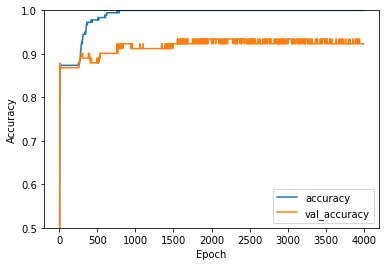

In [43]:
plt.plot(historyI2.history['accuracy'], label='accuracy')
plt.plot(historyI2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
## Accurracy
test_lossFI, test_accFI = model2.evaluate(X_testI, y_testI, verbose=2)
print("Loss: "+str(test_lossFI)+" Accurracy: "+str(test_accFI))

In [44]:
NNI = pd.DataFrame(columns=['Neural Network', 'Accuracy', "loss"])

NNI = NNI.append({"Neural Network":"Sequential", "Accuracy":test_accSI , "loss":test_lossSI }, ignore_index= True)
NNI = NNI.append({"Neural Network":"Functional", "Accuracy":test_accFI , "loss":test_lossFI }, ignore_index= True)

NNI

,Neural Network,Accuracy,loss
0,Sequential,0.747253,0.185067
1,Functional,0.923077,0.066834


In [45]:
accuracyD = pd.DataFrame(columns=['Techniques', 'Name', 'Accuracy'])

for ind, rw in ClassifiersD.iterrows():
    accuracyD = accuracyD.append({"Techniques":"Classifier", "Name":rw["Classifier"], "Accuracy":rw["CA"]}, ignore_index= True)
 
for ind, rw in ClustersD.iterrows():
    accuracyD = accuracyD.append({"Techniques":"Clusters", "Name":rw["Cluster"], "Accuracy":rw["Fowlkes Mallows"]}, ignore_index= True)    

for ind, rw in NNI.iterrows():
    accuracyD = accuracyD.append({"Techniques":"Neural Network", "Name":"NN "+rw["Neural Network"], "Accuracy":rw["Accuracy"]}, ignore_index= True)
    
accuracyD.sort_values('Accuracy',ascending=[False])

,Techniques,Name,Accuracy
0,Classifier,Linear SVM,0.945055
1,Classifier,Random Forest,0.934066
2,Classifier,Logistic Regresion,0.934066
4,Classifier,Decision Tree,0.934066
9,Neural Network,NN Functional,0.923077
3,Classifier,KNN,0.901099
7,Clusters,Affinity Propagation,0.797480
5,Clusters,K-means,0.793070
8,Neural Network,NN Sequential,0.747253
6,Clusters,Means Shift,0.192671


In [46]:
accuracyI = pd.DataFrame(columns=['Techniques', 'Name', 'Accuracy'])

for ind, rw in ClassifiersI.iterrows():
    accuracyI = accuracyI.append({"Techniques":"Classifier", "Name":rw["Classifier"], "Accuracy":rw["CA"]}, ignore_index= True)
 
for ind, rw in ClustersI.iterrows():
    accuracyI = accuracyI.append({"Techniques":"Clusters", "Name":rw["Cluster"], "Accuracy":rw["Fowlkes Mallows"]}, ignore_index= True)    

for ind, rw in NNI.iterrows():
    accuracyI = accuracyI.append({"Techniques":"Neural Network", "Name":"NN "+rw["Neural Network"], "Accuracy":rw["Accuracy"]}, ignore_index= True)
    
accuracyI.sort_values('Accuracy',ascending=[False])

,Techniques,Name,Accuracy
4,Classifier,Decision Tree,0.945055
10,Neural Network,NN Functional,0.923077
0,Classifier,Linear SVM,0.912088
3,Classifier,KNN,0.912088
2,Classifier,Logistic Regresion,0.901099
1,Classifier,Random Forest,0.868132
7,Clusters,Affinity Propagation,0.797480
5,Clusters,K-means,0.793070
9,Neural Network,NN Sequential,0.747253
8,Clusters,Affinity Propagation,0.740729
